In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt

import os

import numpy as np

from CNN import SimpleCNN

from odl_funcs.ellipses import EllipsesDataset

from sirf.STIR import MessageRedirector, ImageData, AcquisitionData, AcquisitionModelUsingRayTracingMatrix
import sirf.STIR
from sirf.Utilities import examples_data_path
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')

msg = MessageRedirector()
sirf.STIR.set_verbosity(0)

attn_image = ImageData(os.path.join(data_path, 'attenuation.hv'))
template = AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))
radon_transform = AcquisitionModelUsingRayTracingMatrix()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#%% make sure figures appears inline and animations works
%matplotlib inline

# Setup the working directory for the notebook
import notebook_setup
from sirf_exercises import cd_to_working_dir
cd_to_working_dir('PET', 'ML_reconstruction')

#%% Initial imports etc
import numpy as np
import scipy.stats
from scipy import ndimage
from scipy.ndimage import affine_transform
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys
import shutil
from numba import njit, prange
#%% Read in images
import brainweb
from tqdm import tqdm
#import scipy
#from scipy import optimize
import sirf.STIR as pet
import sirf.Reg as reg
from sirf.Utilities import examples_data_path
from sirf_exercises import exercises_data_path
pet.set_verbosity(0)

# increase dpi of matplotlib figures
plt.rcParams['figure.dpi'] = 200

# define the directory with input files for this notebook
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')

/home/sirfuser/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
# set-up redirection of STIR messages to files
msg_red = MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')

# big plots
plt.rcParams['figure.dpi'] = 200

In [4]:
def normalise_image(image):
    """Normalise image to range [0,1]"""
    image = image - image.min()
    image = image / image.max()
    return image

In [5]:
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis", vmin=None, vmax=None):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap, vmin=vmin, vmax=vmax)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
#     plt.title(f"{title} (min: {vol.min():.2f}, max: {vol.max():.2f})")
    plt.title(title)
    plt.axis("off")
    

    
def make_positive(image_array):
    """truncate any negatives to zero"""
    image_array[image_array<0] = 0
    return image_array

def make_cylindrical_FOV(image):
    """truncate to cylindrical FOV"""
    filter = pet.TruncateToCylinderProcessor()
    filter.apply(image)

def crop(img, cropx, cropy):
    z,y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[:, starty:starty+cropy,startx:startx+cropx]

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage import filters

def cal_rmse(image1, image2):
    """
    Function to compute Root Mean Square Error (RMSE) between two images.
    """
    return np.sqrt(np.mean((image1 - image2) ** 2))

# def create_mask(image):
#     """
#     Function to create a binary mask for the brain area in an image using Otsu's thresholding method.
#     """
#     # Apply Otsu's thresholding method to binarize the image
#     mask = image < filters.threshold_otsu(image)
#     return mask

def create_mask(image):
    """
    Function to create a binary mask for the brain area in an image using Otsu's thresholding method.
    This version excludes all pixels with a value of 0 in the original image.
    """
    # Apply Otsu's thresholding method to binarize the image
    otsu_mask = image < filters.threshold_otsu(image)
    
    # Create a mask to exclude zero values
    zero_mask = image != 0
    
    # Combine the Otsu mask with the zero mask using logical AND operation
    combined_mask = otsu_mask & zero_mask
    
    return combined_mask


# Test

mMR ground truths: 100%|██████████| 1/1 [00:00<00:00,  3.09subject/s]


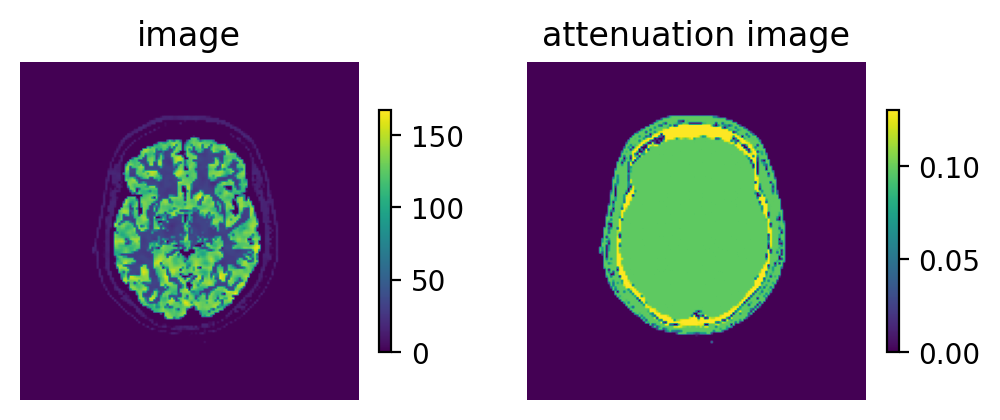

In [16]:
fname, url= sorted(brainweb.utils.LINKS.items())[2]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)
from tqdm import tqdm

brainweb.seed(1337)
# brainweb.seed(1330)


for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1)

FDG_arr  = vol['PET']
T1_arr   = vol['T1']
uMap_arr = vol['uMap']

# function to zoom out and crop the brainweb images
fdg_zoomed = crop(ndimage.zoom(FDG_arr, 1, order=1), 155, 155) # crop and zoom image
fdg_zoomed = np.expand_dims(fdg_zoomed[50,:,:], axis = 0) # expand for pseudo 3D

umap_zoomed = crop(ndimage.zoom(uMap_arr, 1, order=1), 155, 155) # crop and zoom image
umap_zoomed = np.expand_dims(umap_zoomed[50,:,:], axis = 0) # expand for pseudo 3D

image_template = pet.ImageData(os.path.join(data_path, 'emission.hv'))
image = image_template.clone().fill(fdg_zoomed)
attn_image = image_template.clone().fill(umap_zoomed)

template = pet.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))

# This is what our simulated images look like
plt.figure()
plot_2d_image([1,2,1], image.as_array()[0,:], "image")
plot_2d_image([1,2,2], attn_image.as_array()[0,:], "attenuation image")
plt.show()

In [17]:
#%% save max for future displays
cmax = image.max()*.6
# create acquisition model matrix (this uses something called ray tracing, which you can ignore for this example)
# This is a 3-D (or in our case 2-D) Radon Transform matrix
acq_model_matrix  = pet.RayTracingMatrix()
# we will increase the number of rays used for every Line-of-Response (LOR) used in the calculation
acq_model_matrix.set_num_tangential_LORs(5)
# We can now create the acquisition model using this matrix
acq_model = pet.AcquisitionModelUsingMatrix(acq_model_matrix)
acq_model_for_attn = pet.AcquisitionModelUsingRayTracingMatrix() # this saves us a line of code but is the same as in the previous cell=
asm_attn = pet.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
# we can now find the attenuation sensitivity factors for each LOR by forward projecting a uniform image.
# We can set the value of this uniform image to be our detector efficiency. For now, let's just use 1.
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
# add the detector sensitivity (based on the attenuation image) that we made previously
acq_model.set_acquisition_sensitivity(pet.AcquisitionSensitivityModel(attn_factors))
# set-up
acq_model.set_up(template,image)
#%% simulate some data using forward projection
acquired_data=acq_model.forward(image)

In [18]:
def add_noise(proj_data,noise_factor = 0.1, seed = 50):
    """Add Poission noise to acquisition data."""
    proj_data_arr = proj_data.as_array() / noise_factor
    # Data should be >=0 anyway, but add abs just to be safe
    np.random.seed(seed)
    noisy_proj_data_arr = np.random.poisson(proj_data_arr).astype('float32');
    noisy_proj_data = proj_data.clone()
    noisy_proj_data.fill(noisy_proj_data_arr*noise_factor);
    return noisy_proj_data

def affine_transform_2D(theta, tx, ty, sx, sy, image_arr):
    ''' create a random affine transformation for 2D images '''
    # create the transformation matrix
    transformation_matrix = np.array([[sx*np.cos(theta), -sy*np.sin(theta), tx],
                                        [sx*np.sin(theta),  sy*np.cos(theta), ty],
                                        [0, 0, 1]])

    # apply the transformation
    image_arr_transformed = affine_transform(image_arr, transformation_matrix, order=1)
    return image_arr_transformed


In [19]:
noisy_data = add_noise(acquired_data,1)
sens_image = acq_model.backward(template.get_uniform_copy(1))

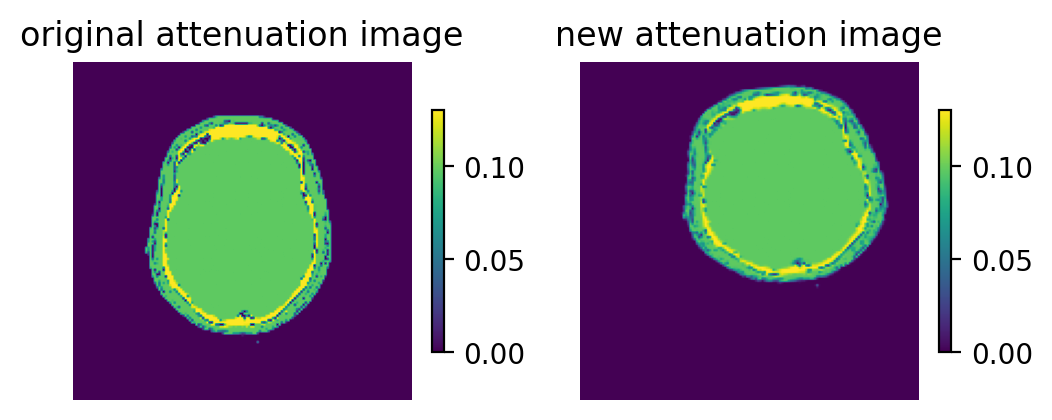

In [25]:
vol_attn = attn_image.as_array()

# apply a random affine transformation using np.random
# theta = np.random.uniform(-np.pi/32, np.pi/32)
# tx, ty = np.random.uniform(-1, 1), np.random.uniform(-1, 1)
# sx, sy = np.random.uniform(0.98, 1.08), np.random.uniform(0.98, 1.08)

theta = np.random.uniform(-np.pi/8, np.pi/8)    # Increased from pi/32 to pi/8
tx, ty = np.random.uniform(-3, 3), np.random.uniform(-3, 3)  # Increased range from (-1, 1) to (-3, 3)
sx, sy = np.random.uniform(0.90, 1.15), np.random.uniform(0.90, 1.15)  # Adjusted range from (0.98, 1.08) to (0.90, 1.15)

vol_transformed = affine_transform_2D(theta, tx, ty, sx, sy, vol_attn[0,:])

vol_transformed = np.expand_dims(vol_transformed, axis=0)

attn_image_transform = attn_image.clone().fill(vol_transformed)

vol_im = image.as_array()
vol_transformed = affine_transform_2D(theta, tx, ty, sx, sy, vol_im[0,:])
vol_transformed = np.expand_dims(vol_transformed, axis=0)

image_transform = image.clone().fill(vol_transformed)

plt.figure()
plot_2d_image([1,2,1], attn_image.as_array()[0,:], "original attenuation image")
plot_2d_image([1,2,2], attn_image_transform.as_array()[0,:], "new attenuation image")
plt.show()

In [26]:
acq_model_for_attn_transform = pet.AcquisitionModelUsingRayTracingMatrix() # this saves us a line of code but is the same as in the previous cell
# We now create the sensitivity model using the acquisition model and the attenuation image
asm_attn_transform = pet.AcquisitionSensitivityModel(attn_image_transform, acq_model_for_attn_transform)
asm_attn_transform.set_up(template)
attn_factors_transform = asm_attn_transform.forward(template.get_uniform_copy(1))
# And then add the detector sensitivity (based on the attenuation image) that we made previously
acq_model_transform = pet.AcquisitionModelUsingRayTracingMatrix()
acq_model_transform.set_acquisition_sensitivity(asm_attn_transform)
# set-up
acq_model_transform.set_up(template,image)
sens_image_transform = acq_model_transform.backward(template.get_uniform_copy(1))

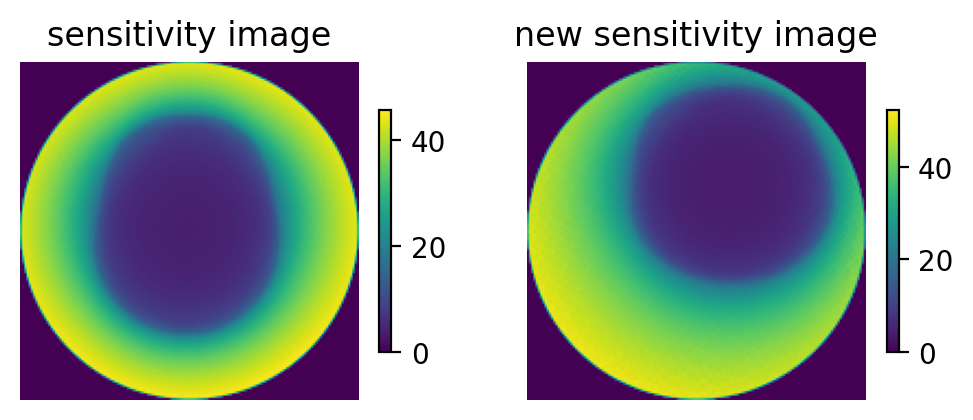

In [27]:
plt.figure()
plot_2d_image([1,2,1], sens_image.as_array()[0,:], "sensitivity image")
plot_2d_image([1,2,2], sens_image_transform.as_array()[0,:], "new sensitivity image")
plt.show()

In [28]:
@njit
def division(arr1, arr2):
    tmp  = np.zeros_like(arr1).flatten()
    for i in prange(tmp.size):
        if arr2.flatten()[i] != 0:
            tmp[i] = arr1.flatten()[i]/arr2.flatten()[i]
        else:
            tmp[i] = 0
    return tmp.reshape(arr1.shape)

# This function performs a single MLEM update
def MLEM_step(input_image, acq_model, acquired_data, sensitivity_image):
    # forward projection
    forward_projected_data = acq_model.forward(input_image)
    # divide acquired data by forward projected data
    ratio = acquired_data.divide(forward_projected_data)
    # back projection
    back_projected_data = acq_model.backward(ratio)
    # divide by sensitivity image
    back_projected_data.fill(division(back_projected_data.as_array(), sensitivity_image.as_array()))
    # update input image
    output_image = input_image*back_projected_data
    return output_image

In [29]:
initial_image=image.get_uniform_copy(cmax / 4)
make_cylindrical_FOV(initial_image)
im_slice = initial_image.dimensions()[0] // 2
obj_fun = pet.make_Poisson_loglikelihood(noisy_data)
obj_fun.set_acquisition_model(acq_model)
obj_fun.set_acquisition_data(noisy_data)
obj_fun.set_up(image)
radon_transform = pet.AcquisitionModelUsingRayTracingMatrix()
radon_transform.set_up(template, image)

In [30]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, acquired_data, sens_image)
    # store results
    obj_fun_value = obj_fun.value(current_image)
    osem_objective_function_values.append(obj_fun_value)
    all_osem_images[i,:,:,:] =  current_image.as_array()

In [31]:
noisy_data_transform = add_noise(acq_model_transform.forward(image_transform),1) # new noisy data
obj_fun_transform = pet.make_Poisson_loglikelihood(noisy_data_transform)
obj_fun_transform.set_acquisition_model(acq_model_transform)
obj_fun_transform.set_acquisition_data(noisy_data_transform)
obj_fun_transform.set_up(image_transform)

#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_transform = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_transform = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_transform[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, noisy_data_transform, sens_image)
    # store results
    obj_fun_value = obj_fun_transform.value(current_image)
    osem_objective_function_values_transform.append(obj_fun_value)
    all_osem_images_transform[i,:,:,:] =  current_image.as_array()

In [32]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_transform_corr = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_transform_corr = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_transform_corr[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, noisy_data_transform, sens_image_transform)
    # store results
    obj_fun_value = obj_fun_transform.value(current_image)
    osem_objective_function_values_transform_corr.append(obj_fun_value)
    all_osem_images_transform_corr[i,:,:,:] =  current_image.as_array()

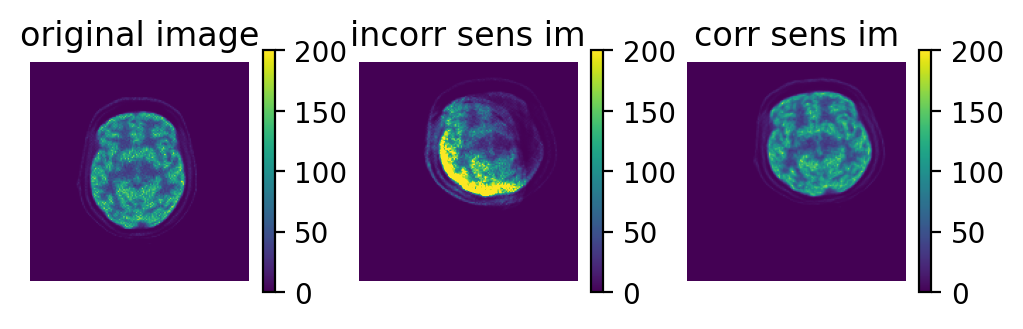

In [33]:
plot_2d_image([1,3,1], all_osem_images[-1][0,:], "original image", clims = [0,200])
plot_2d_image([1,3,2], all_osem_images_transform[-1][0,:], "incorr sens im", clims = [0,200])
plot_2d_image([1,3,3], all_osem_images_transform_corr[-1][0,:], "corr sens im", clims = [0,200])

# Network

## CNN

In [20]:
# Import a file that can generate the shepp logan phantom
from odl_funcs.ellipses import EllipsesDataset
# Import standard extra packages
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim

mini_batch = 10
from sirf.Utilities import examples_data_path


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class SimpleCNN(nn.Module):
    """ 
    A CNN for PET sensitivity estimation.
    Consists of 3 convolutional layers with ReLU activation. 
    Kernel sizes are 15x15, 9x9, 5x5, 3x3, 3x3, 7x7, 15x15, 3x3, 3x3 with padding 
    The idea of this is to have a large kernel size at the beginning to capture
    the large motion, and then gradually reduce the kernel size to capture the
    smaller motion.
    The kernel sizes then increases again to provide an edge filtering effect on a blurry image
    A ReLU activation is used after each convolutional layer.
    Input:
        2 images (sensitivity with no motion and attenuation correction map)
    Output:
        1 image (sensitivity with motion)
    """

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, 15, padding=7)
        self.conv2 = nn.Conv2d(16, 32, 9, padding=4)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, 7, padding=3)
        self.conv6 = nn.Conv2d(32, 16, 15, padding=7)
        self.conv7 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv8 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        x[:,1,:,:]=x[:,1,:,:].mul(10)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        return x

In [22]:
mini_batch = 2
train_dataloader = torch.utils.data.DataLoader( \
    EllipsesDataset(radon_transform, attn_image, template, mode="train", n_samples = 16) \
    , batch_size=mini_batch, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader( \
    EllipsesDataset(radon_transform, attn_image, template, mode="valid", n_samples = 4) \
    , batch_size=mini_batch, shuffle=False)

In [23]:
loss_function = nn.MSELoss()
model = SimpleCNN()
# model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.0000001) # really small learning rate because we should be (almost) at the optimum already

In [24]:
# model.load_state_dict(torch.load("/home/sirfuser/devel/Wei/SIRF-Exercises/notebooks/PET_sensitivity/model_cnn_large.pt", map_location=device))
# model = SimpleCNN()
model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/model_SimpleCNN_10000_2-1.pt", map_location=device))
# model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/U_model_2-1.pth", map_location=device))

model.eval()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(2, 16, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (conv2): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv6): Conv2d(32, 16, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (conv7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [25]:
input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_transform.as_array()]))).unsqueeze(0)
# input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_transform.as_array(),attn_image.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)
out = model(input_data)
sens_image_NN_c = sens_image.clone().fill(out.detach().cpu().numpy()[0,:,:,:])

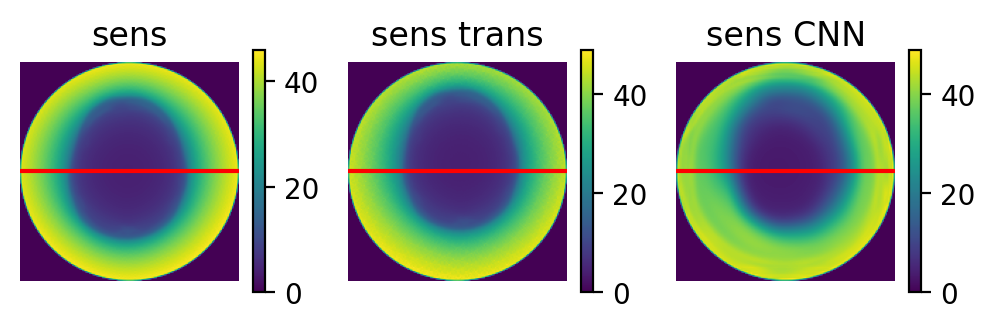

In [26]:
plot_2d_image([1,3,1], sens_image.as_array()[0,:,:], 'sens', cmap="viridis")
plt.plot([0, sens_image.as_array().shape[1]-1], [155//2, 155//2], color="red")

plot_2d_image([1,3,2], sens_image_transform.as_array()[0,:,:], 'sens trans', cmap="viridis")
plt.plot([0, sens_image_transform.as_array().shape[1]-1], [155//2, 155//2], color="red")

plot_2d_image([1,3,3], sens_image_NN_c.as_array()[0,:,:], 'sens CNN', cmap="viridis")
plt.plot([0, sens_image_NN_c.as_array().shape[1]-1], [155//2, 155//2], color="red")

plt.savefig('/home/sirfuser/devel/share_data/c1.png')

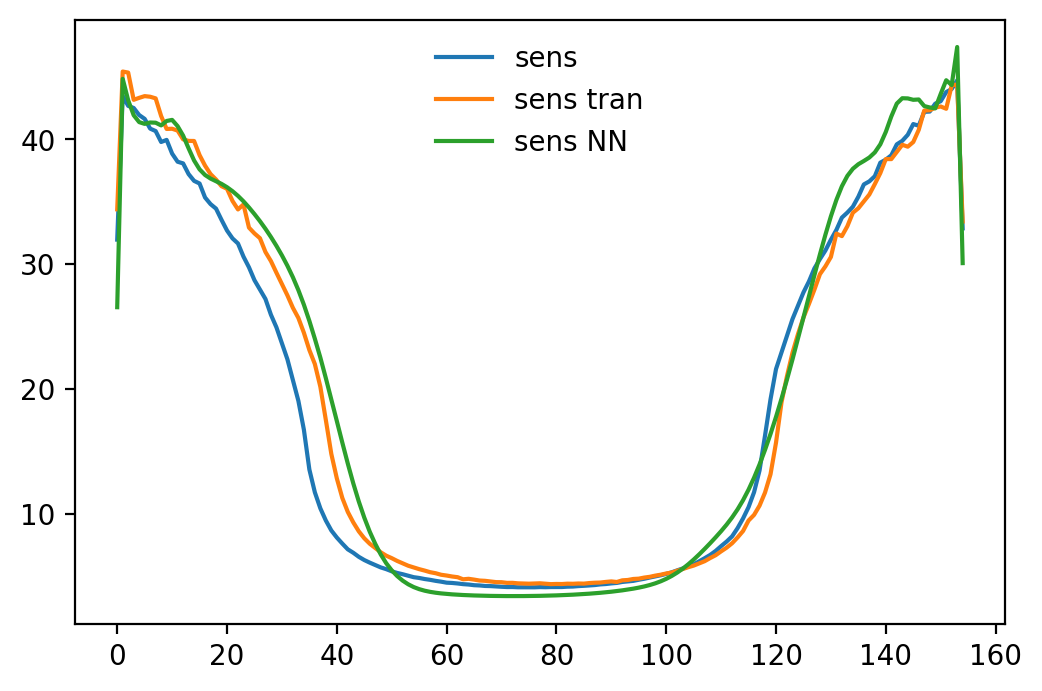

In [27]:
plt.plot(sens_image.as_array()[0,155//2,:],label = 'sens')
plt.plot(sens_image_transform.as_array()[0,155//2,:],label='sens tran')
plt.plot(sens_image_NN_c.as_array()[0,155//2,:],label = 'sens NN')
plt.legend(frameon=False)

plt.savefig('/home/sirfuser/devel/share_data/c2.png')

0.040005725


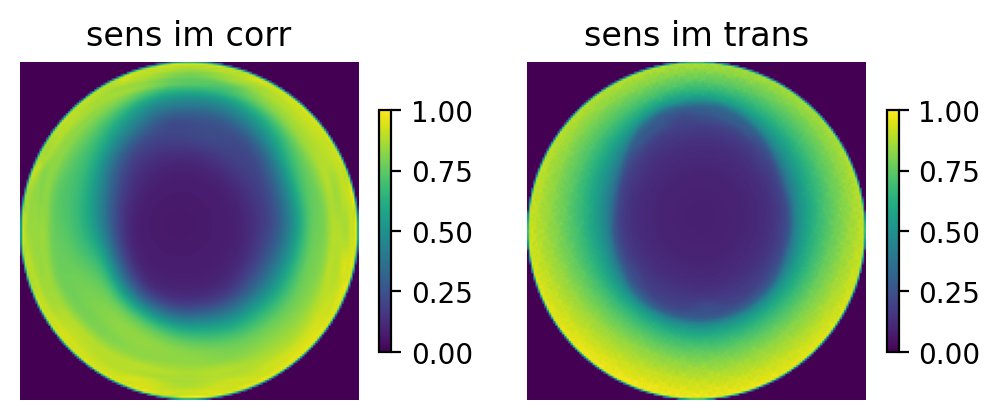

In [28]:
n_sens_image_NN_c = normalise_image(sens_image_NN_c.as_array()[0,:,:])
n_sens_image_transform = normalise_image(sens_image_transform.as_array()[0,:,:])
plot_2d_image([1,2,1], n_sens_image_NN_c , 'sens im corr', cmap="viridis")
plot_2d_image([1,2,2], n_sens_image_transform , 'sens im trans', cmap="viridis")

mse_s = cal_rmse(n_sens_image_NN_c, n_sens_image_transform)
print(mse_s)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage import filters

def cal_rmse(image1, image2):
    """
    Function to compute Root Mean Square Error (RMSE) between two images.
    """
    return np.sqrt(np.mean((image1 - image2) ** 2))

def create_mask(image):
    """
    Function to create a binary mask for the brain area in an image using Otsu's thresholding method.
    This version excludes all pixels with a value of 0 in the original image.
    """
    # Apply Otsu's thresholding method to binarize the image
    otsu_mask = image < filters.threshold_otsu(image)
    
    # Create a mask to exclude zero values
    zero_mask = image != 0
    
    # Combine the Otsu mask with the zero mask using logical AND operation
    combined_mask = otsu_mask & zero_mask
    
    return combined_mask

def create_center_mask(image_shape, radius):
    """
    Create a binary mask with a circle of given radius at the center of the image.
    The circle is True (or 1) and the rest is False (or 0).
    """
    h, w = image_shape
    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    mask = (y - center_y) ** 2 + (x - center_x) ** 2 <= radius ** 2
    return mask



In [30]:
# Load the images
image1 = sens_image_transform.as_array()[0,:,:]
image2 = sens_image_NN_c.as_array()[0,:,:]

# Create masks for the images
mask1 = create_mask(image1)
mask2 = create_mask(image2)

# Calculate the RMSE within the masked regions
rmse_masked = cal_rmse(image1[mask1 & mask2], image2[mask1 & mask2])
print("RMSE (masked):", rmse_masked)

RMSE (masked): 2.0065644


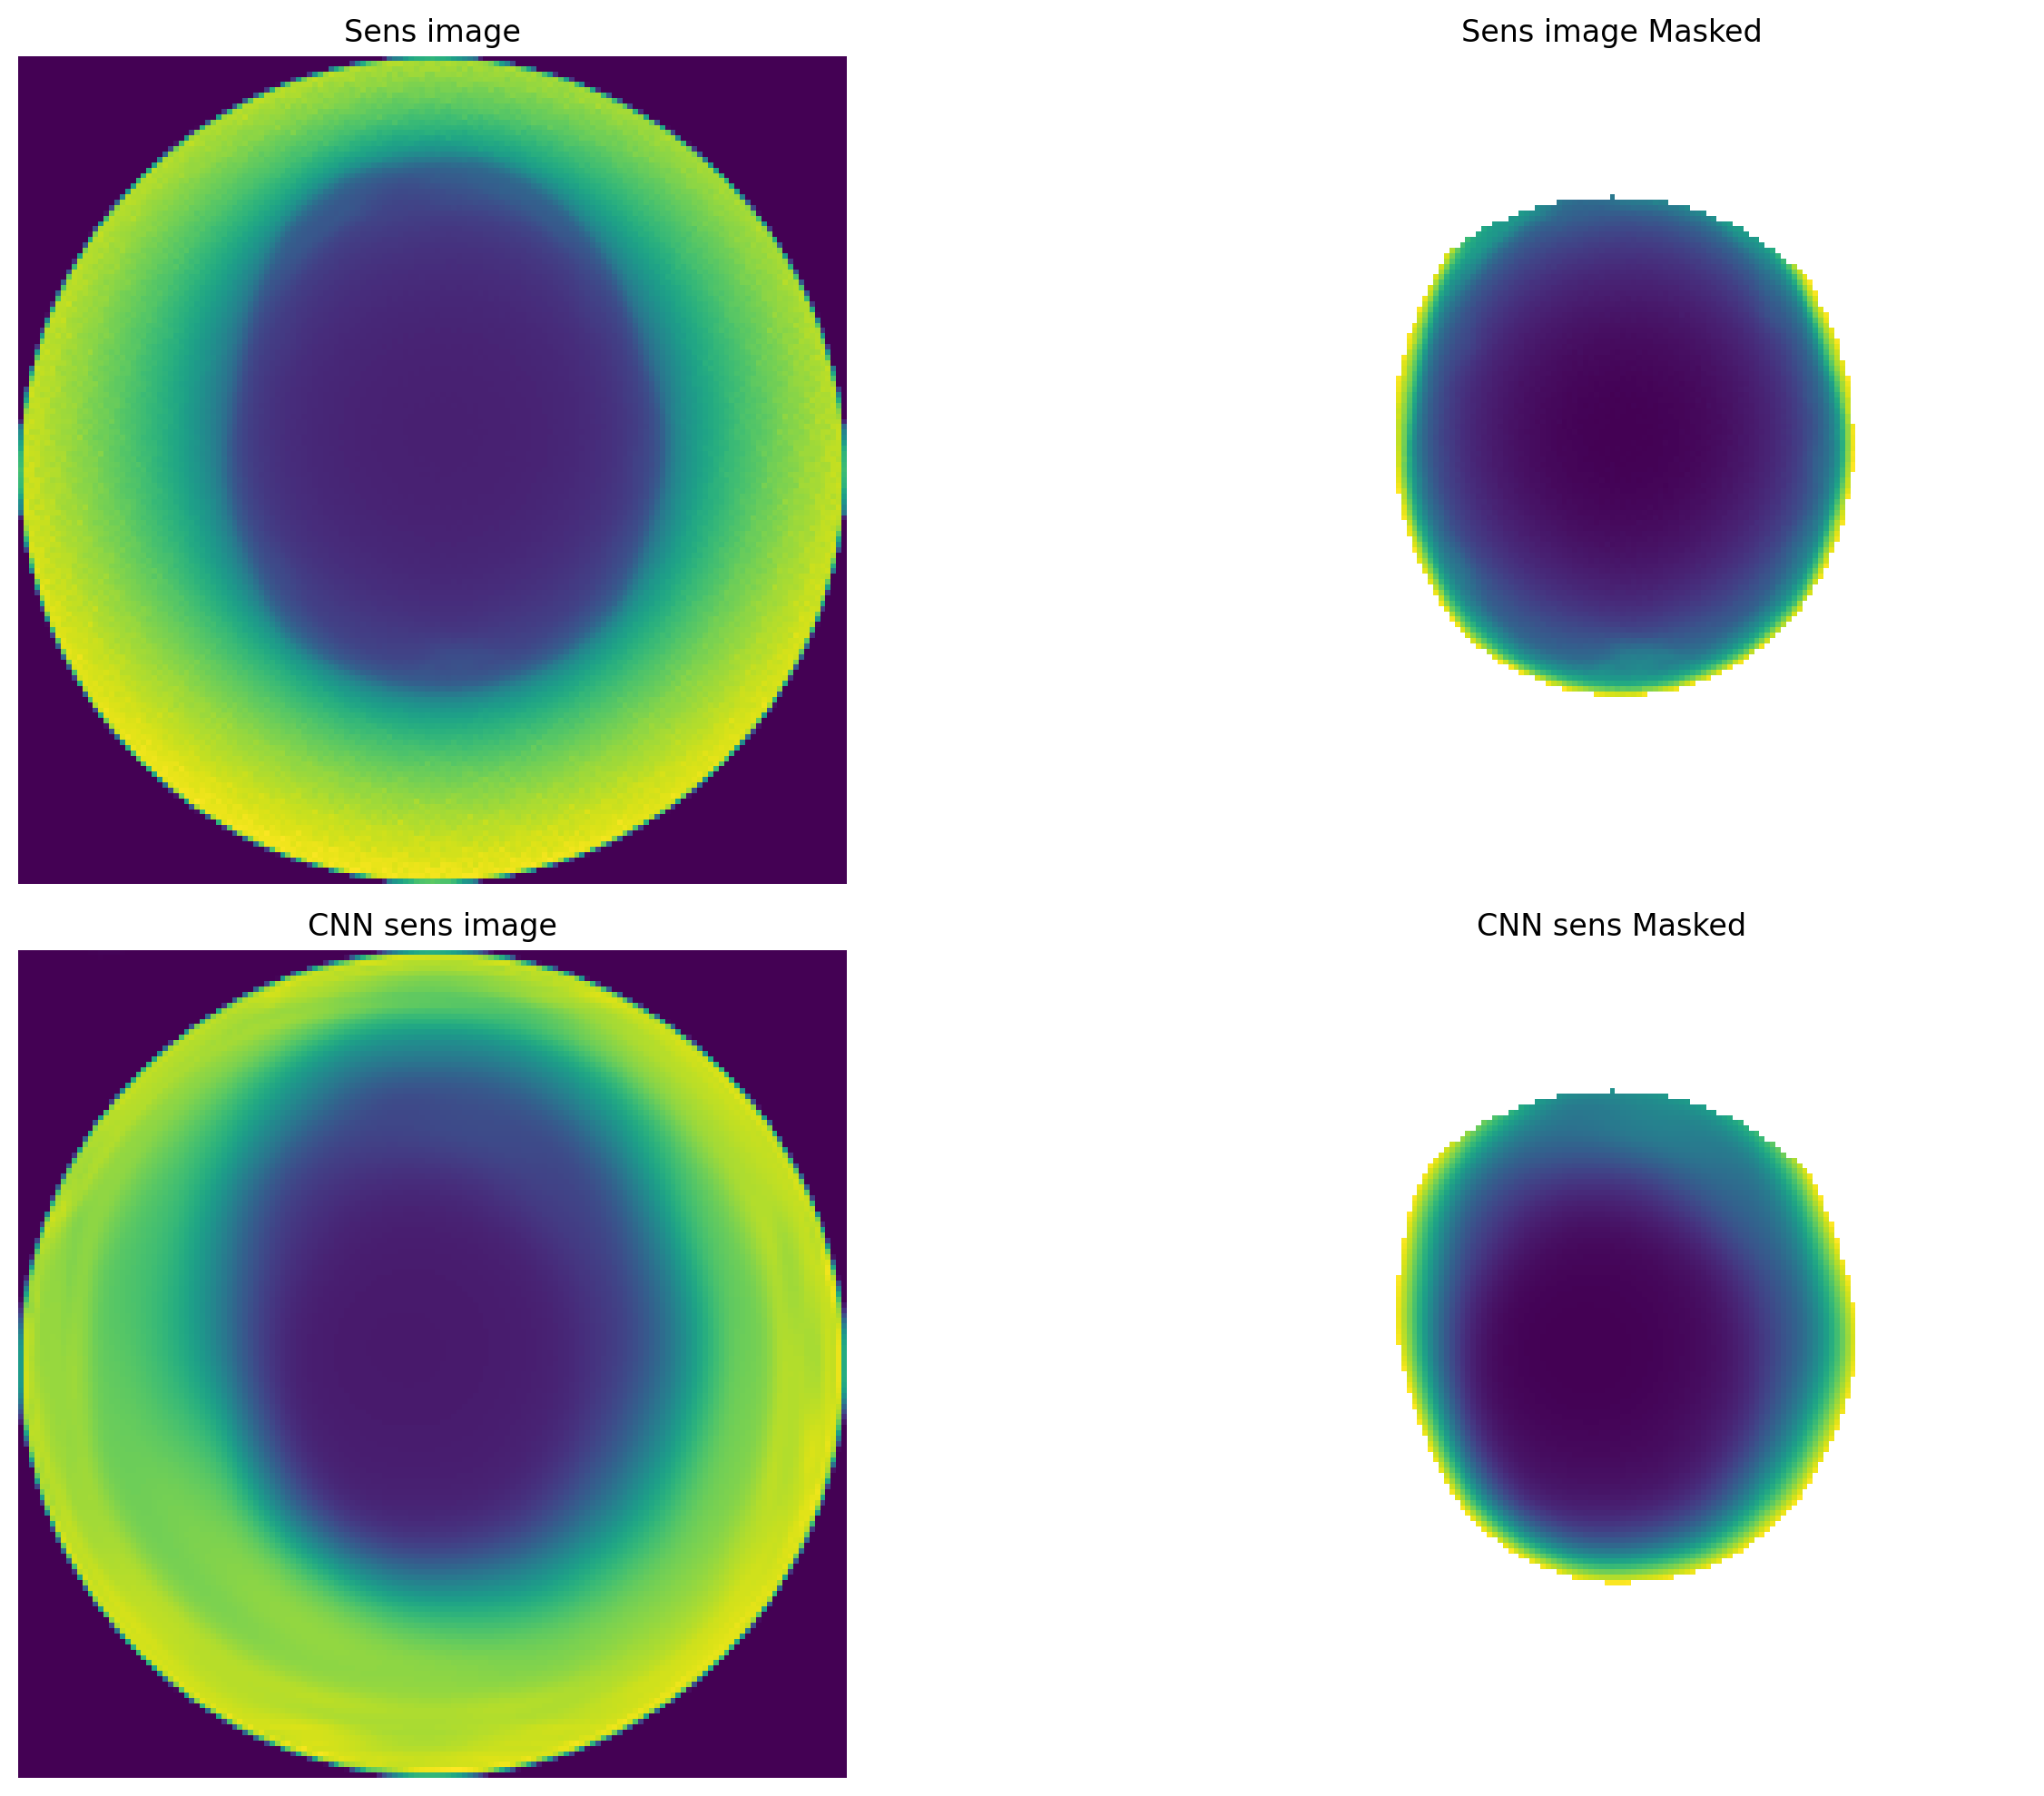

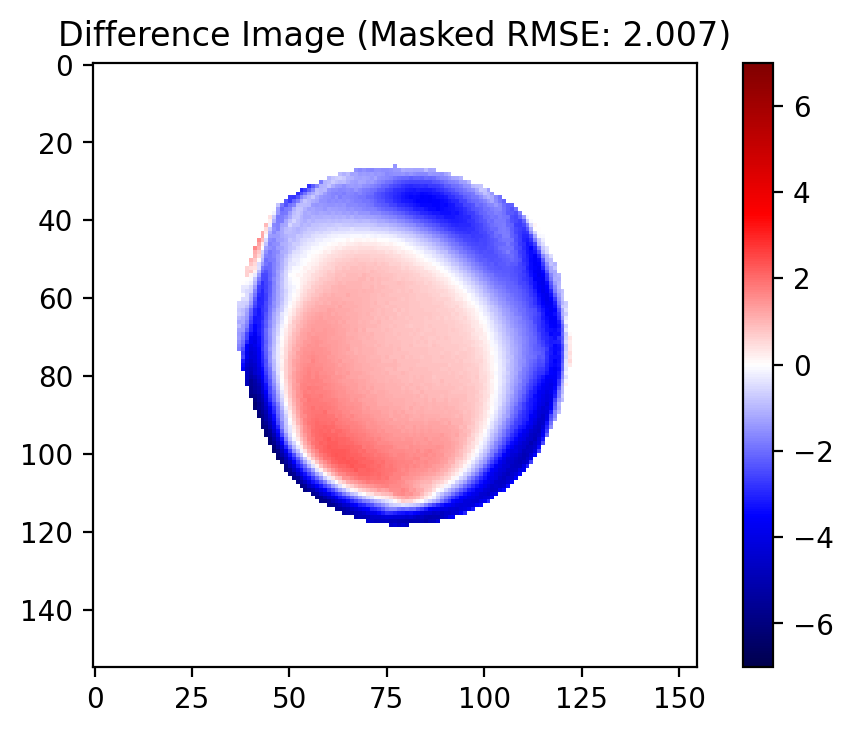

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Given image shape and desired radius
image_shape = image1.shape
radius = min(image_shape) // 3

# Create a center mask
center_mask = create_center_mask(image_shape, radius)

# Apply the center mask to the original masks
new_mask1 = mask1 & center_mask
new_mask2 = mask2 & center_mask

# Apply the new mask to the images
new_masked_image1 = np.where(new_mask1, image1, np.nan)
new_masked_image2 = np.where(new_mask2, image2, np.nan)

# Create a figure for plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the original images and masks
axs[0, 0].imshow(image1)
axs[0, 0].set_title('Sens image')
axs[1, 0].imshow(image2)
axs[1, 0].set_title('CNN sens image')

axs[0, 1].imshow(new_masked_image1)
axs[0, 1].set_title('Sens image Masked')
axs[1, 1].imshow(new_masked_image2)
axs[1, 1].set_title('CNN sens Masked')

# Remove axis labels and tick marks
for ax in axs.flat:
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Save the figure
output_path = '/home/sirfuser/devel/share_data'
output_filename = 'c3.png'
output_filepath = os.path.join(output_path, output_filename)
plt.savefig(output_filepath)

# Compute the difference image with the new mask
diff_image = new_masked_image1 - new_masked_image2

# Plot the difference image with the masked RMSE as the title
plt.figure()
im = plt.imshow(diff_image, cmap='seismic',vmin=-7, vmax=7)
plt.title(f'Difference Image (Masked RMSE: {rmse_masked:.3f})')
plt.colorbar(im)
output_filepath = os.path.join(output_path, 'c4.png')
plt.savefig(output_filepath)
# Show the combined figure
plt.show()


In [32]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image_NN = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_NN = [obj_fun.value(current_image_NN)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_NN_c = np.ndarray(shape=(num_iters + 1,) + current_image_NN.dimensions())
all_osem_images_NN_c[0,:,:,:] = current_image_NN.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image_NN = MLEM_step(current_image_NN, radon_transform, noisy_data_transform, sens_image_NN_c)
    # store results
    all_osem_images_NN_c[i,:,:,:] = current_image_NN.as_array()

In [33]:
mse_nn_c = cal_rmse(all_osem_images_NN_c[-1,0,:,:], all_osem_images_transform_corr[-1,0,:,:])
mse_i_c = cal_rmse(all_osem_images_transform[-1,0,:,:], all_osem_images_transform_corr[-1,0,:,:])
print(mse_nn_c)
print(mse_i_c)

21.57300410868948
11.684853312690567


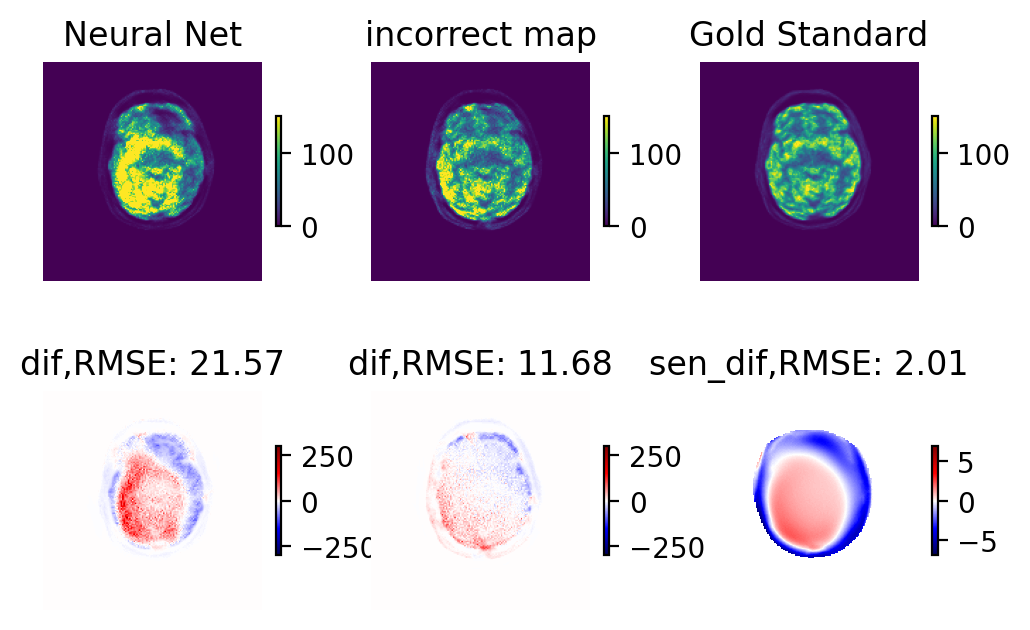

In [34]:
plot_2d_image([2,3,1], all_osem_images_NN_c[-1,0,:,:], 'Neural Net', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,2], all_osem_images_transform[-1,0,:,:], 'incorrect map', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,3], all_osem_images_transform_corr[-1,0,:,:], 'Gold Standard', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,4], all_osem_images_NN_c[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:],  f'dif,RMSE: {mse_nn_c:.2f}', cmap="seismic",vmin=-300, vmax=300)
plot_2d_image([2,3,5], all_osem_images_transform[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:],  f'dif,RMSE: {mse_i_c:.2f}', cmap="seismic",vmin=-300, vmax=300)
plot_2d_image([2,3,6], diff_image, f'sen_dif,RMSE: {rmse_masked:.2f}', cmap="seismic",vmin=-7, vmax=7)

plt.savefig('/home/sirfuser/devel/share_data/cc.png')

In [35]:
# Find the minimum and maximum values
vmin = np.min(all_osem_images_NN_c[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:])
vmax = np.max(all_osem_images_NN_c[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:])
print(vmin,vmax)

-101.49839210510254 296.08277893066406


0.09574168019220967


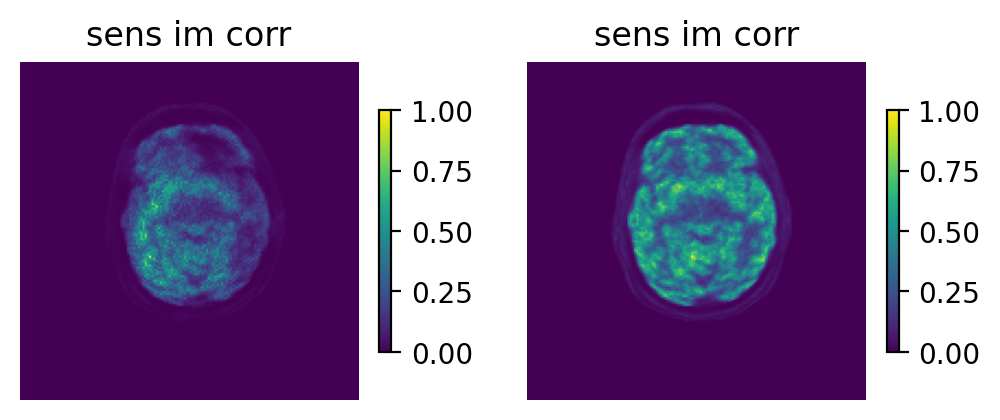

In [36]:
n_all_osem_images_NN_c = normalise_image(all_osem_images_NN_c[-1,0,:,:])
n_all_osem_images_transform_corr = normalise_image(all_osem_images_transform_corr[-1,0,:,:])
plot_2d_image([1,2,1], n_all_osem_images_NN_c, 'sens im corr', cmap="viridis")
plot_2d_image([1,2,2], n_all_osem_images_transform_corr, 'sens im corr', cmap="viridis")

mse = cal_rmse(n_all_osem_images_NN_c, n_all_osem_images_transform_corr)
print(mse)

## U-net

In [37]:
import torch
from torch import nn
from torch.nn import functional as F

class Conv_Block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel//2,1,1)
    def forward(self,x,feature_map):
        up=F.interpolate(x,scale_factor=2,mode='nearest')
        out=self.layer(up)
        return torch.cat((out,feature_map),dim=1)


class UNet(nn.Module):
    def __init__(self,num_classes=1):
        super(UNet, self).__init__()
        self.c1=Conv_Block(2,64)  # change from 3 to 2 input channels
        self.d1=DownSample(64)
        self.c2=Conv_Block(64,128)
        self.d2=DownSample(128)
        self.c3=Conv_Block(128,256)
        self.d3=DownSample(256)
        self.c4=Conv_Block(256,512)
        self.d4=DownSample(512)
        self.c5=Conv_Block(512,1024)
        self.u1=UpSample(1024)
        self.c6=Conv_Block(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv_Block(512, 256)
        self.u3 = UpSample(256)
        self.c8 = Conv_Block(256, 128)
        self.u4 = UpSample(128)
        self.c9 = Conv_Block(128, 64)
        self.out=nn.Conv2d(64,num_classes,3,1,1)

    def forward(self,x):
        # pad input tensor so it has shape [batch_size, 2, 160, 160]
        x = F.pad(input=x, pad=(3, 2, 3, 2), mode='constant', value=0)

        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        O1=self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1, R3))
        O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(O3, R1))
        output = self.out(O4)

        # Crop the output to match target size
        output_cropped = output[..., 3:-2, 3:-2]
        return output_cropped

In [38]:
model = UNet()
model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/U_model_2-1.pth", map_location=device))
model.eval()
model.to(device)

UNet(
  (c1): Conv_Block(
    (layer): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.3, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout2d(p=0.3, inplace=False)
      (7): LeakyReLU(negative_slope=0.01)
    )
  )
  (d1): DownSample(
    (layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (c2): Conv_Block(
    (layer): Sequential(
      (0): Conv2d(64, 

In [72]:

input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_transform.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)
out = model(input_data)
sens_image_NN_u = sens_image.clone().fill(out.detach().cpu().numpy()[0,:,:,:])


Code runtime: 0.2444148063659668 seconds


In [77]:
import time

# Import torch if not already imported
import torch

# Number of iterations
num_iterations = 100
total_runtime = 0

for _ in range(num_iterations):
    # Record the start time
    start_time = time.time()

    sens_image_NN_u = sens_image.clone().fill(out.detach().cpu().numpy()[0,:,:,:])

    # Record the end time
    end_time = time.time()

    # Calculate the runtime and add to total
    runtime = end_time - start_time
    total_runtime += runtime

# Calculate the average runtime
average_runtime = total_runtime / num_iterations
print(f"Average code runtime over {num_iterations} iterations: {average_runtime} seconds")


Average code runtime over 100 iterations: 0.02465343713760376 seconds


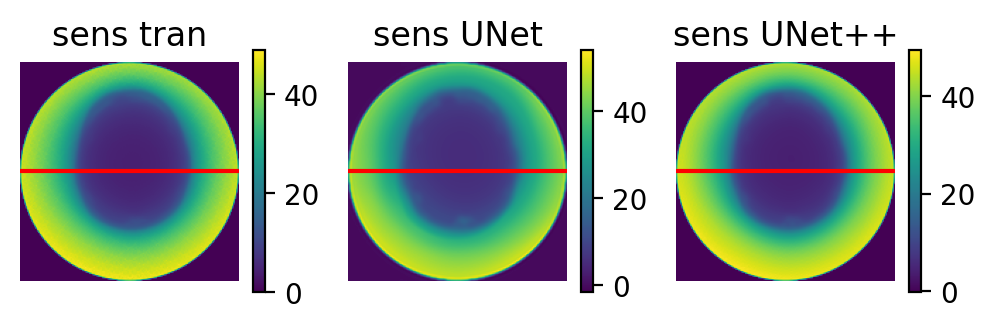

In [62]:
plot_2d_image([1,3,1], sens_image_transform.as_array()[0,:,:], 'sens tran', cmap="viridis")
plt.plot([0, sens_image.as_array().shape[1]-1], [155//2, 155//2], color="red")

plot_2d_image([1,3,2], sens_image_NN_u.as_array()[0,:,:], 'sens UNet', cmap="viridis")
plt.plot([0, sens_image.as_array().shape[1]-1], [155//2, 155//2], color="red")

plot_2d_image([1,3,3], sens_image_NN_u2.as_array()[0,:,:], 'sens UNet++', cmap="viridis")
plt.plot([0, sens_image.as_array().shape[1]-1], [155//2, 155//2], color="red")

plt.savefig('/home/sirfuser/devel/share_data/uu1.png')

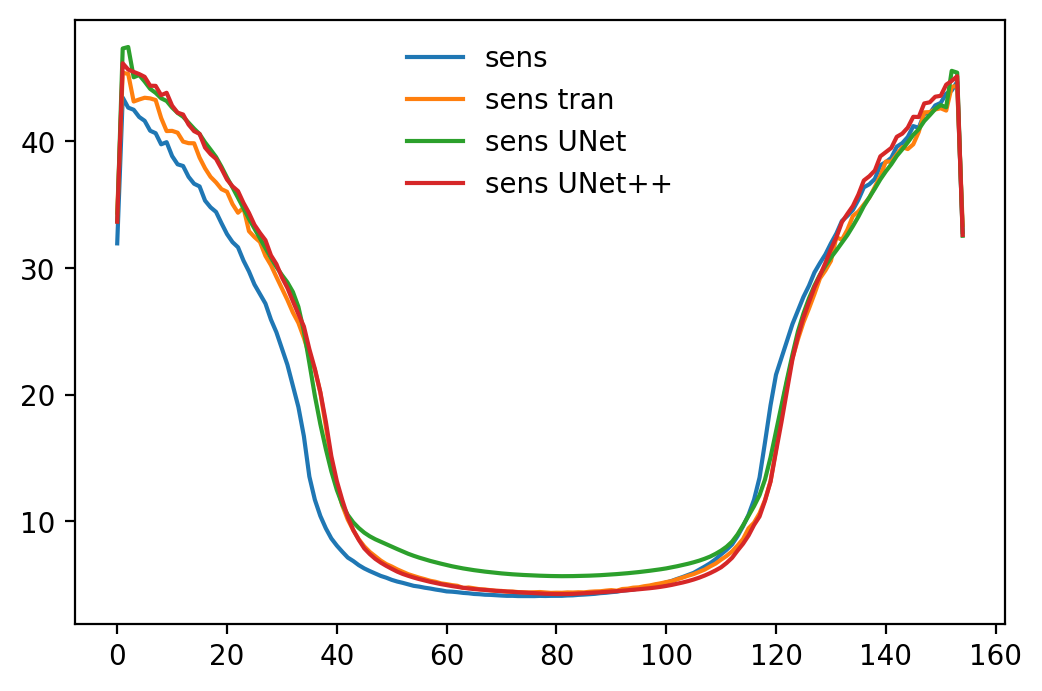

In [64]:
plt.plot(sens_image.as_array()[0,155//2,:],label = 'sens')
plt.plot(sens_image_transform.as_array()[0,155//2,:],label='sens tran')
plt.plot(sens_image_NN_u.as_array()[0,155//2,:],label = 'sens UNet')
plt.plot(sens_image_NN_u2.as_array()[0,155//2,:],label = 'sens UNet++')
plt.legend(frameon=False)

plt.savefig('/home/sirfuser/devel/share_data/uu2.png')

0.05148407


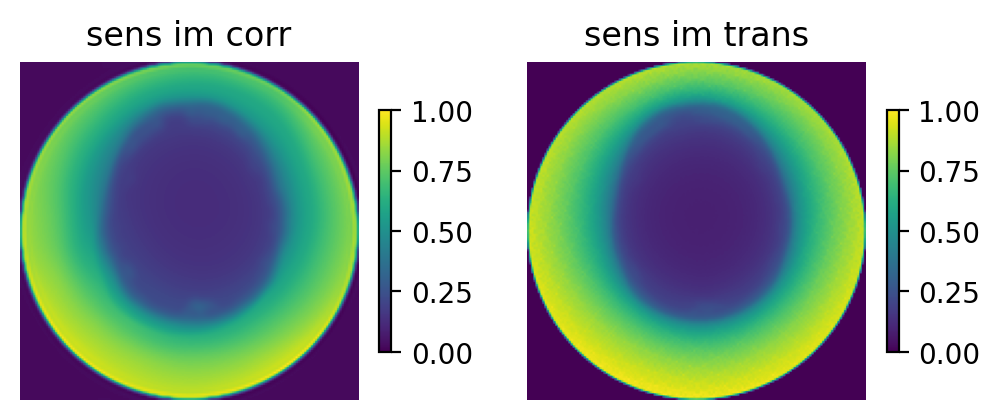

In [42]:
n_sens_image_NN_u = normalise_image(sens_image_NN_u.as_array()[0,:,:])
n_sens_image_transform = normalise_image(sens_image_transform.as_array()[0,:,:])
plot_2d_image([1,2,1], n_sens_image_NN_u , 'sens im corr', cmap="viridis")
plot_2d_image([1,2,2], n_sens_image_transform , 'sens im trans', cmap="viridis")

mse_s = cal_rmse(n_sens_image_NN_u, n_sens_image_transform)
print(mse_s)

In [43]:
# Load the images
image3 = sens_image_transform.as_array()[0,:,:]
image4 = sens_image_NN_u.as_array()[0,:,:]

# Create masks for the images
mask3 = create_mask(image3)
mask4 = create_mask(image4)

# Calculate the RMSE within the masked regions
rmse_masked2 = cal_rmse(image3[mask3 & mask4], image4[mask3 & mask4])
print("RMSE (masked):", rmse_masked2)

RMSE (masked): 1.462234


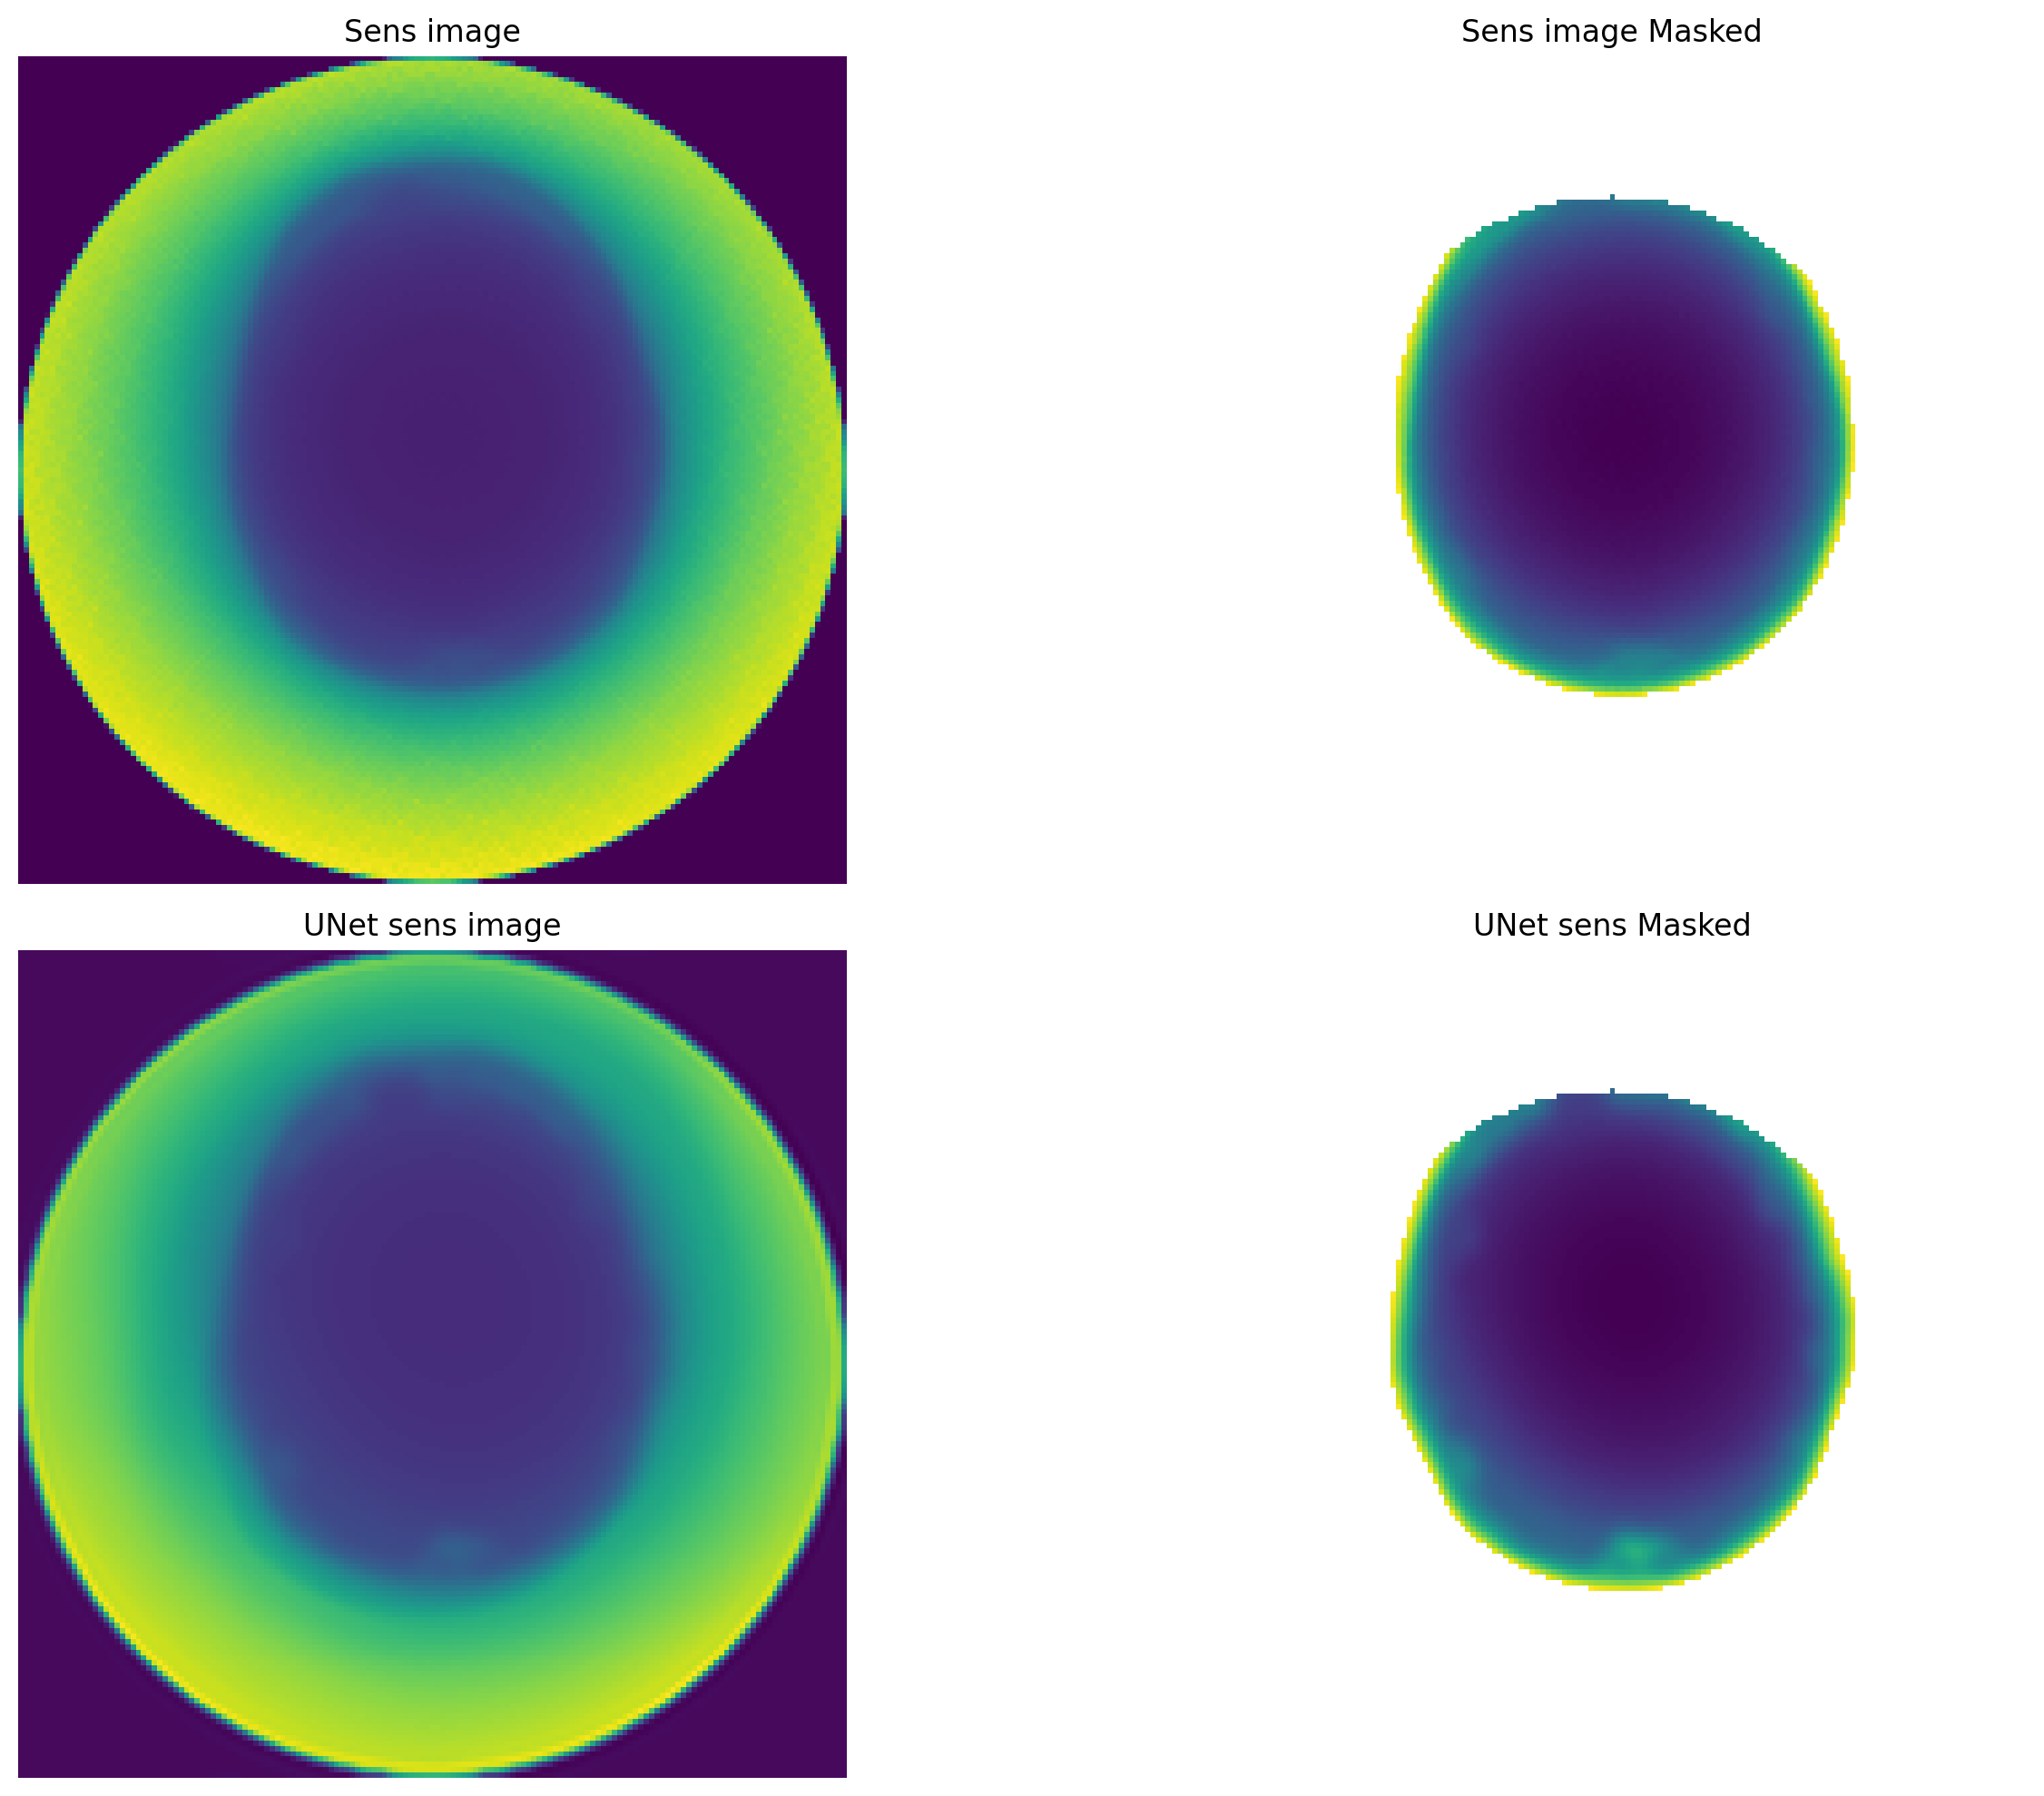

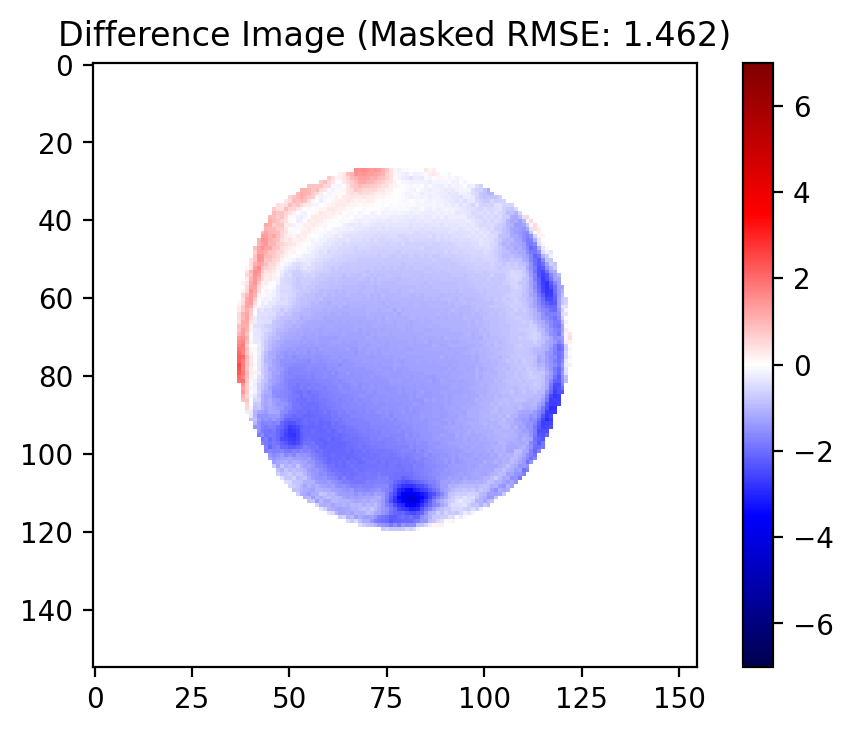

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Given image shape and desired radius
image_shape = image1.shape
radius = min(image_shape) // 3

# Create a center mask
center_mask = create_center_mask(image_shape, radius)

# Apply the center mask to the original masks
new_mask3 = mask3 & center_mask
new_mask4 = mask4 & center_mask

# Apply the new mask to the images
new_masked_image3 = np.where(new_mask3, image3, np.nan)
new_masked_image4 = np.where(new_mask4, image4, np.nan)

# Create a figure for plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the original images and masks
axs[0, 0].imshow(image3)
axs[0, 0].set_title('Sens image')
axs[1, 0].imshow(image4)
axs[1, 0].set_title('UNet sens image')

axs[0, 1].imshow(new_masked_image3)
axs[0, 1].set_title('Sens image Masked')
axs[1, 1].imshow(new_masked_image4)
axs[1, 1].set_title('UNet sens Masked')

# Remove axis labels and tick marks
for ax in axs.flat:
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Save the figure
output_path = '/home/sirfuser/devel/share_data'
output_filename = 'u3.png'
output_filepath = os.path.join(output_path, output_filename)
plt.savefig(output_filepath)

# Compute the difference image with the new mask
diff_image2 = new_masked_image3 - new_masked_image4

# Plot the difference image with the masked RMSE as the title
plt.figure()
im = plt.imshow(diff_image2, cmap='seismic',vmin=-7, vmax=7)
plt.title(f'Difference Image (Masked RMSE: {rmse_masked2:.3f})')
plt.colorbar(im)
output_filepath = os.path.join(output_path, 'u4.png')
plt.savefig(output_filepath)
# Show the combined figure
plt.show()


In [45]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image_NN = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_NN = [obj_fun.value(current_image_NN)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_NN_u = np.ndarray(shape=(num_iters + 1,) + current_image_NN.dimensions())
all_osem_images_NN_u[0,:,:,:] = current_image_NN.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image_NN = MLEM_step(current_image_NN, radon_transform, noisy_data_transform, sens_image_NN_u)
    # store results
    all_osem_images_NN_u[i,:,:,:] = current_image_NN.as_array()

In [46]:
mse_nn_u = cal_rmse(all_osem_images_NN_u[-1,0,:,:], all_osem_images_transform_corr[-1,0,:,:])
mse_i_u = cal_rmse(all_osem_images_transform[-1,0,:,:], all_osem_images_transform_corr[-1,0,:,:])
print(mse_nn_u)
print(mse_i_u)

10.315969433183318
11.684853312690567


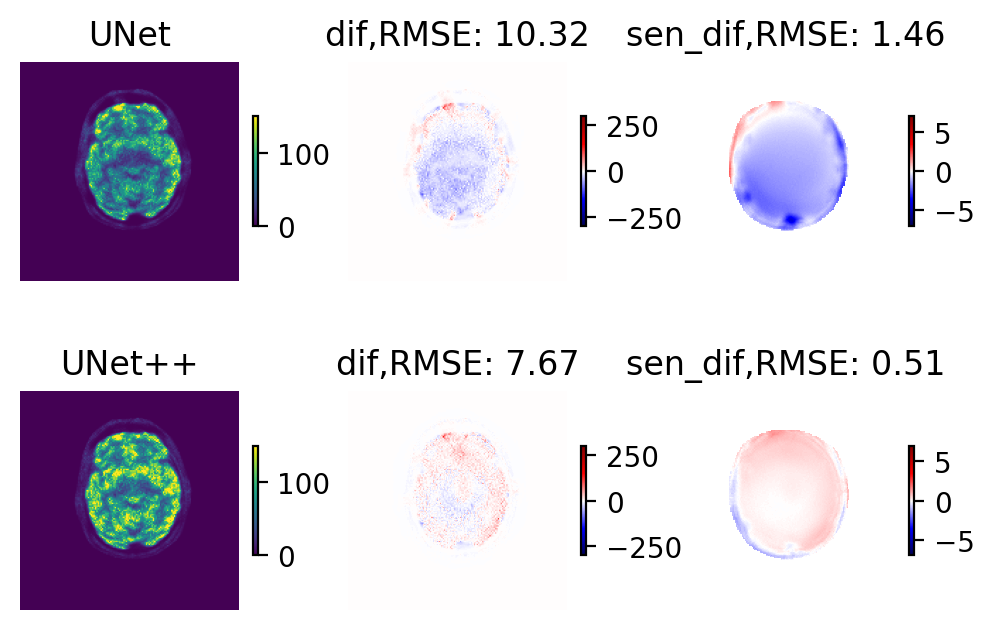

In [68]:
plot_2d_image([2,3,1], all_osem_images_NN_u[-1,0,:,:], 'UNet', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,4], all_osem_images_NN_u2[-1,0,:,:], 'UNet++', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,6], diff_image3, f'sen_dif,RMSE: {rmse_masked3:.2f}', cmap="seismic",vmin=-7, vmax=7)
plot_2d_image([2,3,2], all_osem_images_NN_u[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], f'dif,RMSE: {mse_nn_u:.2f}', cmap="seismic",vmin=-300, vmax=300)
plot_2d_image([2,3,5], all_osem_images_NN_u2[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], f'dif,RMSE: {mse_nn_u2:.2f}', cmap="seismic",vmin=-300, vmax=300)
plot_2d_image([2,3,3], diff_image2, f'sen_dif,RMSE: {rmse_masked2:.2f}', cmap="seismic",vmin=-7, vmax=7)
plt.savefig('/home/sirfuser/devel/share_data/uuc.png')

0.061589746947151525
0.08198865744938101


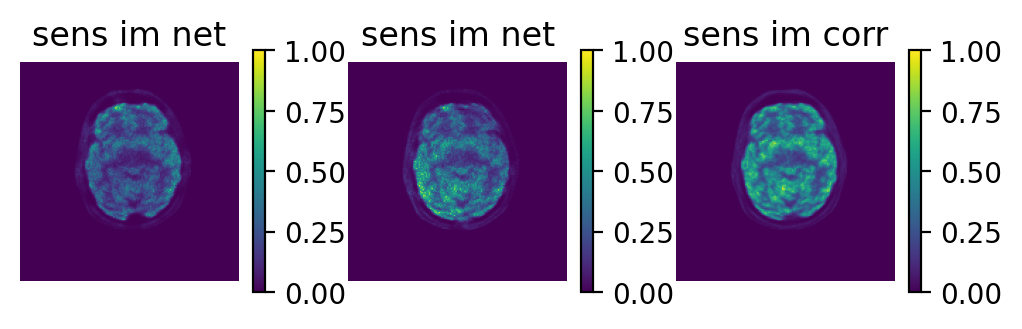

In [48]:
n_all_osem_images_NN_u = normalise_image(all_osem_images_NN_u[-1,0,:,:])
n_all_osem_images_transform_corr = normalise_image(all_osem_images_transform_corr[-1,0,:,:])
n_all_osem_images_transform = normalise_image(all_osem_images_transform[-1,0,:,:])
plot_2d_image([1,3,1], n_all_osem_images_NN_u, 'sens im net', cmap="viridis")
plot_2d_image([1,3,2], n_all_osem_images_transform, 'sens im net', cmap="viridis")
plot_2d_image([1,3,3], n_all_osem_images_transform_corr, 'sens im corr', cmap="viridis")

m = cal_rmse(n_all_osem_images_transform, n_all_osem_images_transform_corr)
mse = cal_rmse(n_all_osem_images_NN_u, n_all_osem_images_transform_corr)
print(m)
print(mse)

## UNet++

In [114]:
import torch
from torch import nn
from torch.nn import functional as F

__all__ = ['UNet', 'NestedUNet']


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes=1, input_channels=2, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        # print('input:',input.shape)
        x0_0 = self.conv0_0(input)
        x0_0 = F.pad(input=x0_0, pad=(3, 2, 3, 2), mode='constant', value=0)
        # print('x0_0:',x0_0.shape)
        x1_0 = self.conv1_0(self.pool(x0_0))
        # print('x1_0:',x1_0.shape)
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        # print('x0_1:',x0_1.shape)

        x2_0 = self.conv2_0(self.pool(x1_0))
        # print('x2_0:',x2_0.shape)
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        # print('x1_1:',x1_1.shape)
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        # print('x0_2:',x0_2.shape)

        x3_0 = self.conv3_0(self.pool(x2_0))
        # print('x3_0:',x3_0.shape)
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        # print('x2_1:',x2_1.shape)
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        # print('x1_2:',x1_2.shape)
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        # print('x0_3:',x0_3.shape)
        x4_0 = self.conv4_0(self.pool(x3_0))
        # print('x4_0:',x4_0.shape)
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        # print('x3_1:',x3_1.shape)
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        # print('x2_2:',x2_2.shape)
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        # print('x1_3:',x1_3.shape)
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        # print('x0_4:',x0_4.shape)

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            output_cropped = output[..., 3:-2, 3:-2]
            return output_cropped
        
        



In [115]:
model = NestedUNet()
model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/u_p_2-1+_1w_2.pth", map_location=device))
model.eval()
model.to(device)

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

In [116]:
input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_transform.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)
out = model(input_data)
sens_image_NN_u2 = sens_image.clone().fill(out.detach().cpu().numpy()[0,:,:,:])

/home/sirfuser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


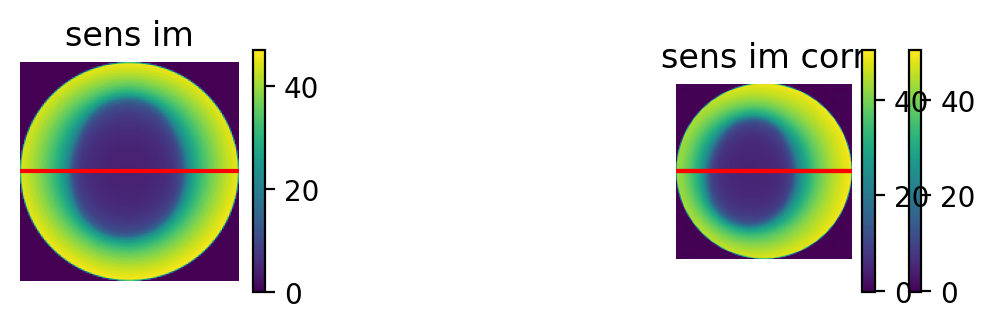

In [117]:
plot_2d_image([1,3,1], sens_image.as_array()[0,:,:], 'sens im', cmap="viridis")
plt.plot([0, sens_image.as_array().shape[1]-1], [155//2, 155//2], color="red")

plot_2d_image([1,3,3], sens_image_NN_u2.as_array()[0,:,:], 'sens im corr', cmap="viridis")

plt.plot([0, sens_image.as_array().shape[1]-1], [155//2, 155//2], color="red")

plot_2d_image([1,3,3], sens_image_NN_u2.as_array()[0,:,:], 'sens im corr', cmap="viridis")

plt.plot([0, sens_image.as_array().shape[1]-1], [155//2, 155//2], color="red")

plt.savefig('/home/sirfuser/devel/share_data/u1+.png')

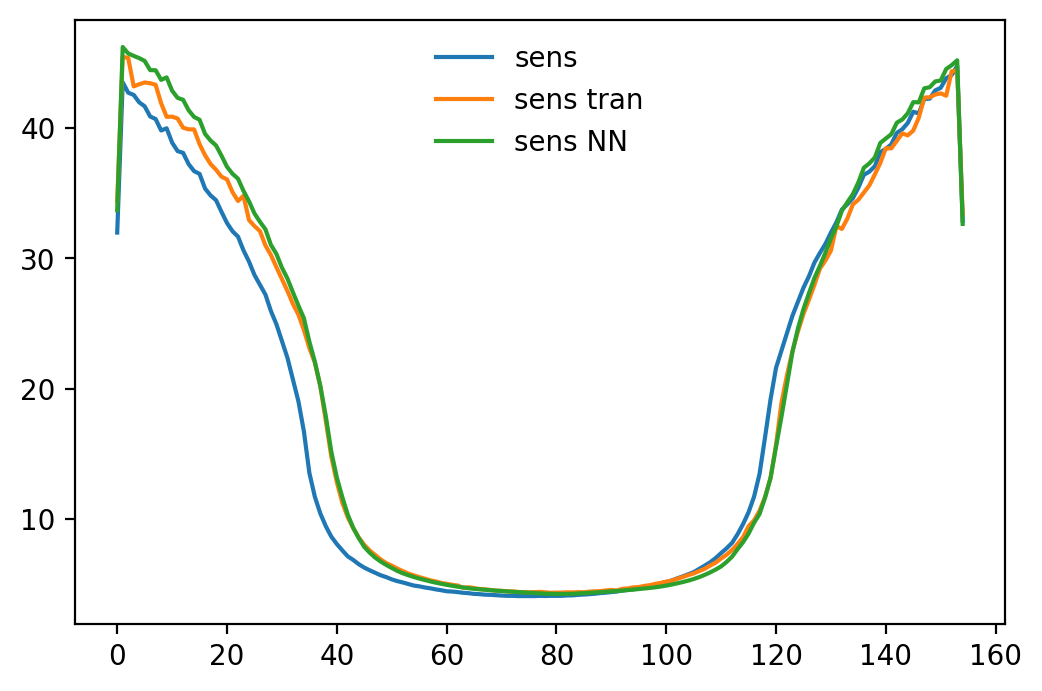

In [53]:
plt.plot(sens_image.as_array()[0,155//2,:],label = 'sens')
plt.plot(sens_image_transform.as_array()[0,155//2,:],label='sens tran')
plt.plot(sens_image_NN_u2.as_array()[0,155//2,:],label = 'sens NN')
plt.legend(frameon=False)

plt.savefig('/home/sirfuser/devel/share_data/u2+.png')

0.05148407


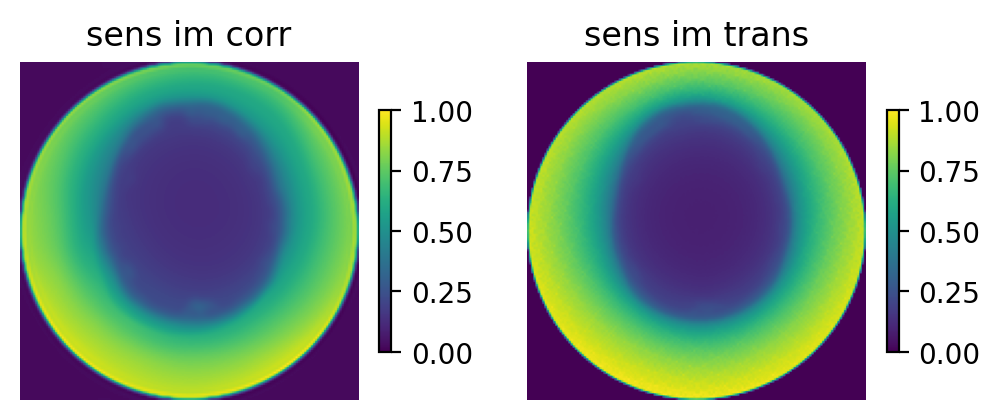

In [54]:
n_sens_image_NN_u = normalise_image(sens_image_NN_u.as_array()[0,:,:])
n_sens_image_transform = normalise_image(sens_image_transform.as_array()[0,:,:])
plot_2d_image([1,2,1], n_sens_image_NN_u , 'sens im corr', cmap="viridis")
plot_2d_image([1,2,2], n_sens_image_transform , 'sens im trans', cmap="viridis")

mse_s = cal_rmse(n_sens_image_NN_u, n_sens_image_transform)
print(mse_s)

In [55]:
# Load the images
image5 = sens_image_transform.as_array()[0,:,:]
image6 = sens_image_NN_u2.as_array()[0,:,:]

# Create masks for the images
mask5 = create_mask(image5)
mask6 = create_mask(image6)

# Calculate the RMSE within the masked regions
rmse_masked3 = cal_rmse(image5[mask5 & mask6], image6[mask5 & mask6])
print("RMSE (masked):", rmse_masked3)

RMSE (masked): 0.5135621


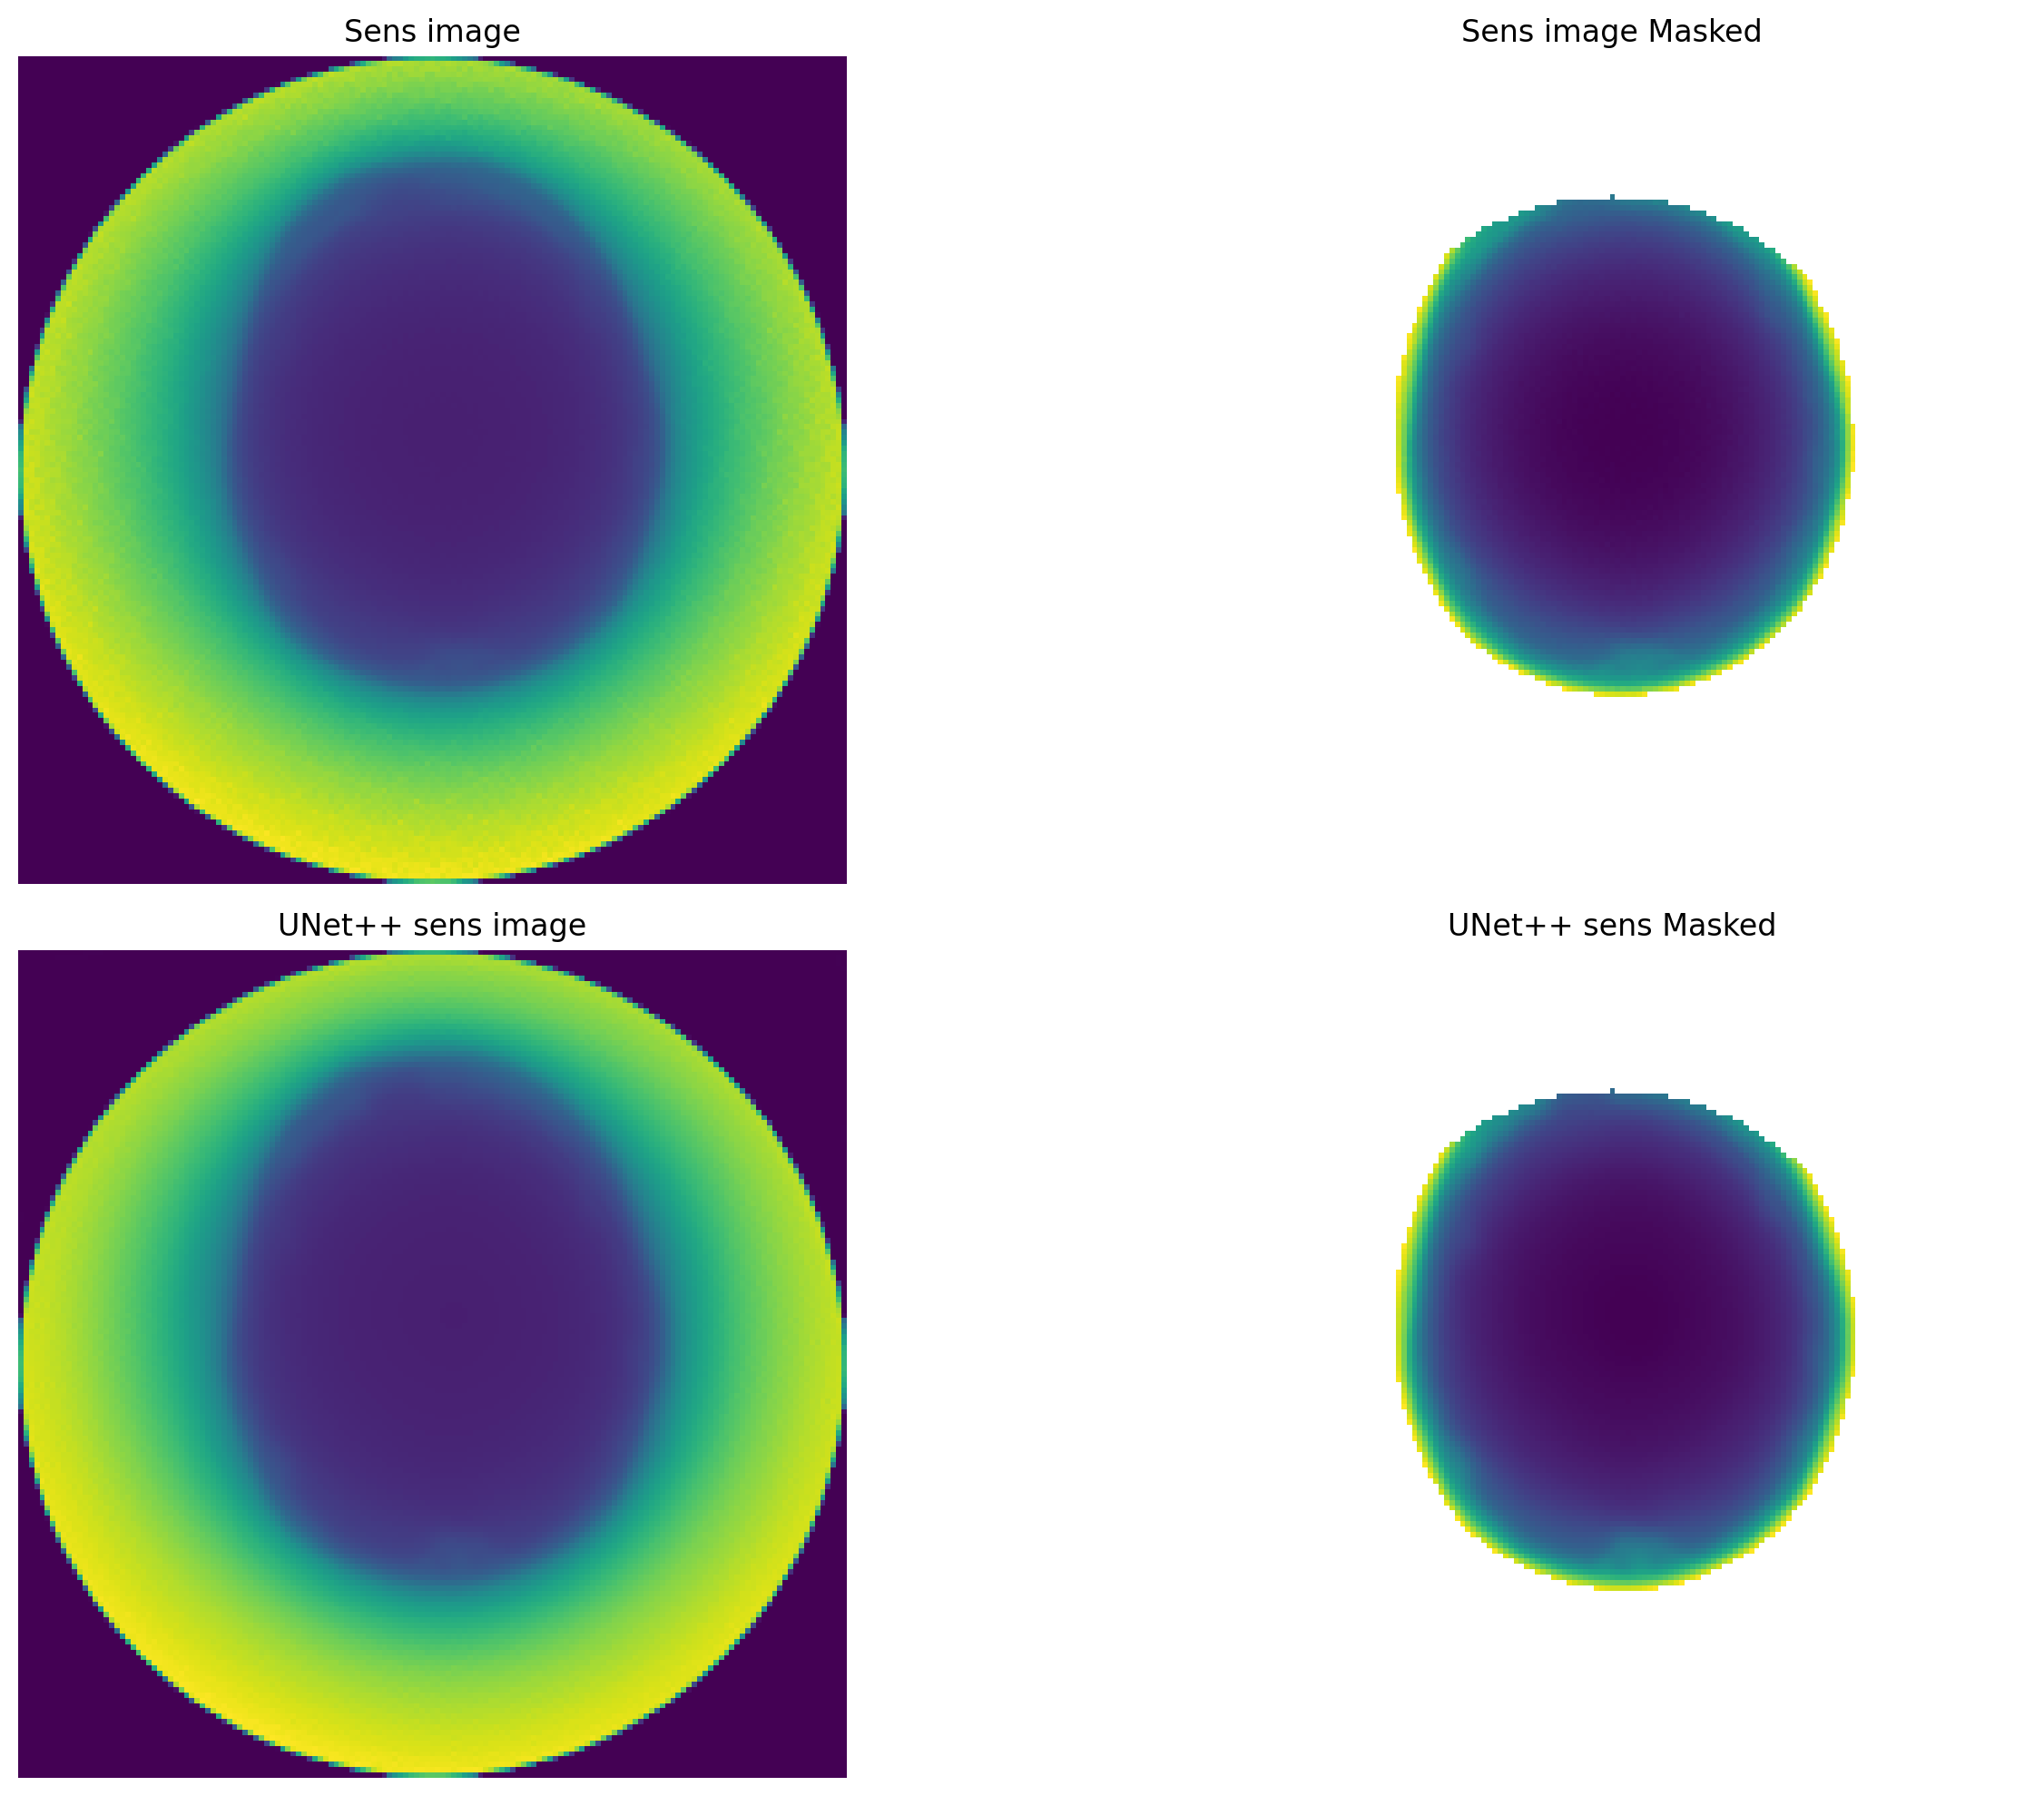

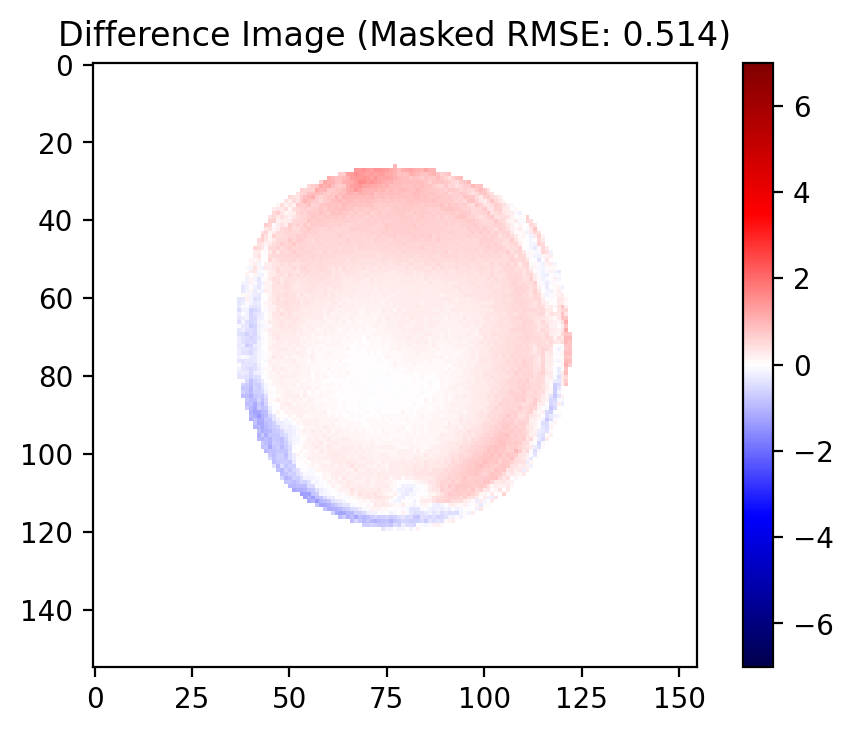

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Given image shape and desired radius
image_shape = image1.shape
radius = min(image_shape) // 3

# Create a center mask
center_mask = create_center_mask(image_shape, radius)

# Apply the center mask to the original masks
new_mask5 = mask5 & center_mask
new_mask6 = mask6 & center_mask

# Apply the new mask to the images
new_masked_image5 = np.where(new_mask5, image5, np.nan)
new_masked_image6 = np.where(new_mask6, image6, np.nan)

# Create a figure for plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the original images and masks
axs[0, 0].imshow(image5)
axs[0, 0].set_title('Sens image')
axs[1, 0].imshow(image6)
axs[1, 0].set_title('UNet++ sens image')

axs[0, 1].imshow(new_masked_image5)
axs[0, 1].set_title('Sens image Masked')
axs[1, 1].imshow(new_masked_image6)
axs[1, 1].set_title('UNet++ sens Masked')

# Remove axis labels and tick marks
for ax in axs.flat:
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Save the figure
output_path = '/home/sirfuser/devel/share_data'
output_filename = 'u3+.png'
output_filepath = os.path.join(output_path, output_filename)
plt.savefig(output_filepath)

# Compute the difference image with the new mask
diff_image3 = new_masked_image5 - new_masked_image6

# Plot the difference image with the masked RMSE as the title
plt.figure()
im = plt.imshow(diff_image3, cmap='seismic',vmin=-7, vmax=7)
plt.title(f'Difference Image (Masked RMSE: {rmse_masked3:.3f})')
plt.colorbar(im)
output_filepath = os.path.join(output_path, 'u4+.png')
plt.savefig(output_filepath)
# Show the combined figure
plt.show()


In [118]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image_NN = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_NN = [obj_fun.value(current_image_NN)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_NN_u2 = np.ndarray(shape=(num_iters + 1,) + current_image_NN.dimensions())
all_osem_images_NN_u2[0,:,:,:] = current_image_NN.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image_NN = MLEM_step(current_image_NN, radon_transform, noisy_data_transform, sens_image_NN_u2)
    # store results
    all_osem_images_NN_u2[i,:,:,:] = current_image_NN.as_array()

In [58]:
mse_nn_u2 = cal_rmse(all_osem_images_NN_u2[-1,0,:,:], all_osem_images_transform_corr[-1,0,:,:])
mse_i_u2 = cal_rmse(all_osem_images_transform[-1,0,:,:], all_osem_images_transform_corr[-1,0,:,:])
print(mse_nn_u2)
print(mse_i_u2)

7.674728435861413
11.684853312690567


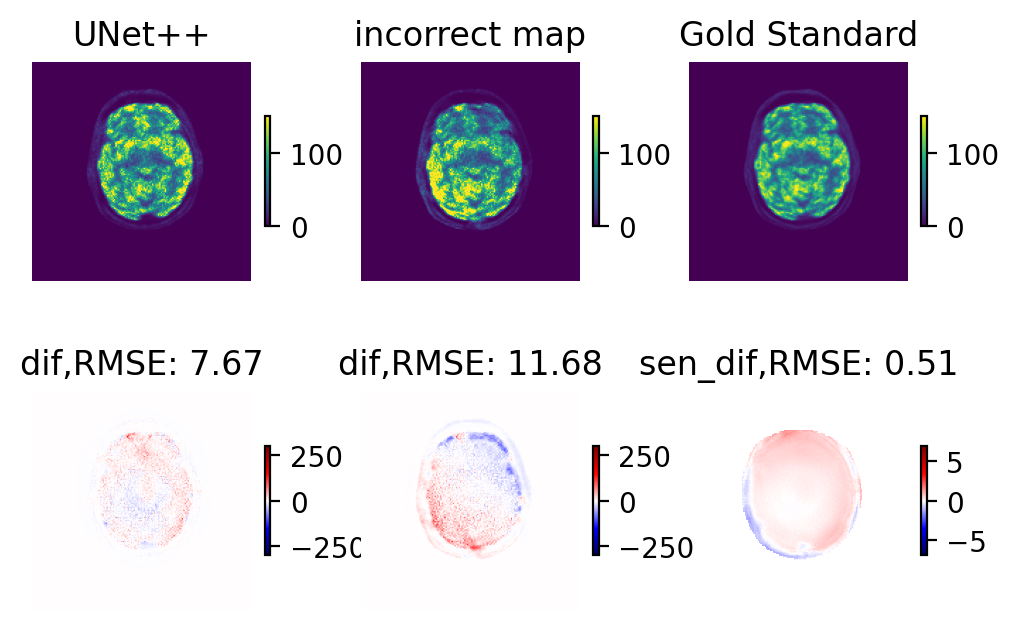

In [59]:
plot_2d_image([2,3,1], all_osem_images_NN_u2[-1,0,:,:], 'UNet++', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,2], all_osem_images_transform[-1,0,:,:], 'incorrect map', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,3], all_osem_images_transform_corr[-1,0,:,:], 'Gold Standard', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,4], all_osem_images_NN_u2[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], f'dif,RMSE: {mse_nn_u2:.2f}', cmap="seismic",vmin=-300, vmax=300)
plot_2d_image([2,3,5], all_osem_images_transform[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], f'dif,RMSE: {mse_i_u2:.2f}', cmap="seismic",vmin=-300, vmax=300)
plot_2d_image([2,3,6], diff_image3, f'sen_dif,RMSE: {rmse_masked3:.2f}', cmap="seismic",vmin=-7, vmax=7)
plt.savefig('/home/sirfuser/devel/share_data/uc+.png')

0.061589746947151525
0.08198865744938101


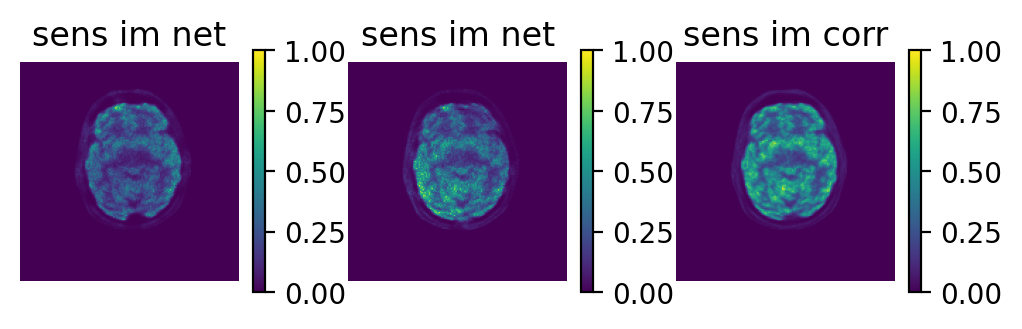

In [60]:
n_all_osem_images_NN_u = normalise_image(all_osem_images_NN_u[-1,0,:,:])
n_all_osem_images_transform_corr = normalise_image(all_osem_images_transform_corr[-1,0,:,:])
n_all_osem_images_transform = normalise_image(all_osem_images_transform[-1,0,:,:])
plot_2d_image([1,3,1], n_all_osem_images_NN_u, 'sens im net', cmap="viridis")
plot_2d_image([1,3,2], n_all_osem_images_transform, 'sens im net', cmap="viridis")
plot_2d_image([1,3,3], n_all_osem_images_transform_corr, 'sens im corr', cmap="viridis")

m = cal_rmse(n_all_osem_images_transform, n_all_osem_images_transform_corr)
mse = cal_rmse(n_all_osem_images_NN_u, n_all_osem_images_transform_corr)
print(m)
print(mse)

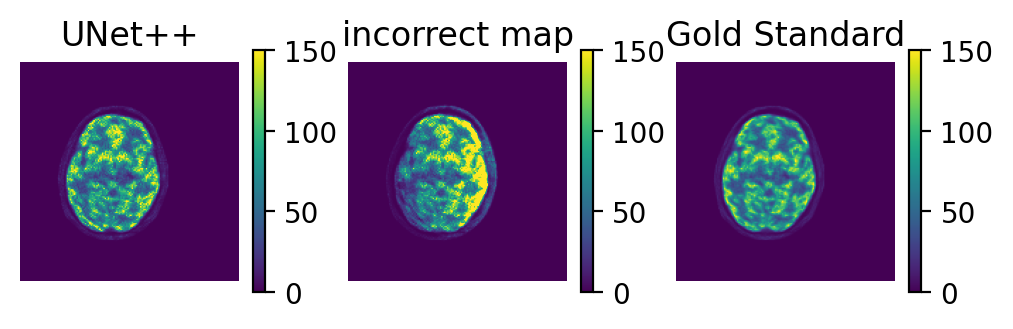

In [119]:
# more example
plot_2d_image([1,3,1], all_osem_images_NN_u2[-1,0,:,:], 'UNet++', cmap="viridis", clims=[0,150])
plot_2d_image([1,3,2], all_osem_images_transform[-1,0,:,:], 'incorrect map', cmap="viridis", clims=[0,150])
plot_2d_image([1,3,3], all_osem_images_transform_corr[-1,0,:,:], 'Gold Standard', cmap="viridis", clims=[0,150])

plt.savefig('/home/sirfuser/devel/share_data/v2.png')